In [1]:
import time
import os
import io

from random import seed
from random import randint

from argparse import ArgumentParser, Namespace
import yaml
from multiprocessing import cpu_count

import matplotlib.pyplot as plt

# default is to maximize the objectives
import time as time
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy.stats import norm

# example of a gaussian process surrogate function
from math import sin
from math import pi
import numpy as np
from numpy import arange
from numpy import asarray
from numpy.random import normal
from numpy.random import uniform
from numpy.random import random
from numpy import cov
from numpy import mean
from numpy import std

from warnings import catch_warnings
from warnings import simplefilter


from autooed.utils.sampling import lhs
import random
#import xgboost as xgb
#from xgboost import XGBRegressor
#from xgboost import plot_tree
from sklearn import linear_model
from sklearn import ensemble
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# loocv to manually evaluate the performance of a random forest classifier
from sklearn.model_selection import LeaveOneOut, cross_val_score

from scipy.stats import pearsonr as pearsonr
from scipy import ndimage, misc
import pickle
import re
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from chainer_chemistry.datasets.molnet import get_molnet_dataset
# the package is in the same directory
# get Today's date from python!
from datetime import datetime
from autooed.utils.sampling import lhs
from autooed.problem import build_problem
from autooed.mobo import build_algorithm
from autooed.utils.seed import set_seed
from autooed.utils.initialization import generate_random_initial_samples, load_provided_initial_samples
from autooed.utils.plot import plot_performance_space, plot_performance_metric
from autooed.utils.plot import plot_performance_space_diffcolor
from argparse import ArgumentParser, Namespace
from arguments import get_args

Printability accuracy on all data 1.0
Tg accuracy on all data group 1 in range of [10, 60] is: 1.0


/home2/Github/MOBO_RFcons_LCD3D_6monomers/autooed/mobo/surrogate_problem.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_print.fit(X_, Y)


In [2]:
#### preprocessing 
# printability as Y
df = pd.read_csv('Yuchao_20220726.csv')

Printability = np.asarray (df['Printability']).reshape(1,-1).T
Tg = np.asarray (df['Tg']).reshape(1,-1).T
Tg[np.isnan(Tg)] = 200
Tg_group = [1 if 10<i<60 else 0 for i in Tg]
Tg_group = np.array(Tg_group)

toughness = np.asarray (df['Toughness(MJ/m3)']).reshape(1,-1).T
toughness[np.isnan(toughness)] = 0
strength = np.asarray (df['Tensile_Strength(MPa)']).reshape(1,-1).T
strength[np.isnan(strength)] = 0
strain = np.asarray (df['Tensile_Strain_percentage']).reshape(1,-1).T
strain[np.isnan(strain)] = 0

Y0 = Printability
Y = np.where(Y0 == 'Y', 1, 0)

#X_ = df.to_numpy()
A_Ratio = np.asarray (df['R1(HA)']).reshape(1,-1)
B_Ratio = np.asarray (df['R2(IA)']).reshape(1,-1)
C_Ratio = np.asarray (df['R3(NVP)']).reshape(1,-1)
D_Ratio = np.asarray (df['R4(AA)']).reshape(1,-1)
E_Ratio = np.asarray (df['R5(HEAA)']).reshape(1,-1)
F_Ratio = np.asarray (df['R6(IBOA)']).reshape(1,-1)

# did not consider F_Ratio, since we do not have it in optimization
X_ = np.concatenate((A_Ratio.T, B_Ratio.T, C_Ratio.T, D_Ratio.T, E_Ratio.T), axis=1)


# load monomers descriptors
df = pd.read_csv('monomers_info.csv')
energy = np.array (-df['dft_sp_E_RB3LYP'])
pol_area = np.array (df['polar_surface_area'])
complexity = np.array (df['complexity'])
HA = np.array (df['HA'])
solubility = np.array (df['solubility_sqrt_MJperm3'])
solubility_d = np.array (df['solubility_dipole'])
solubility_h = np.array (df['solubility_h'])
solubility_p = np.array (df['solubility_p'])

X0 = np.concatenate((A_Ratio.T, B_Ratio.T, C_Ratio.T, D_Ratio.T, E_Ratio.T, F_Ratio.T), axis=1)
X_energy = np.multiply (X0, energy)
#X_pol_area = np.multiply (X0, pol_area)
X_complexity = np.multiply (X0, complexity)
X_HA = np.multiply (X0, HA)
X_solubility_d = np.multiply (X0, solubility_d)
X_solubility_h = np.multiply (X0, solubility_h)
X_solubility_p = np.multiply (X0, solubility_p)

X = np.concatenate ((X_energy, X_complexity, X_HA, 
                    X_solubility_d, X_solubility_h, X_solubility_p), axis=1)

# got more information about input varialbe may reduce the accuracy for 
# few samples, but it is informative for new samples.
# The hyperparameters are fixed using one-leave-out in file "leavout_CV_RF_printability_Tg.ipynb"
RF_print = RandomForestClassifier(random_state=0, 
                                  max_depth = 5, 
                                  n_estimators = 50)
RF_print.fit(X, Y)
Yhat = RF_print.predict(X)
acc = accuracy_score(Y, Yhat)
print('Accuracy: %.3f' % acc)
#print (RF_print.get_params(deep=True))

RF_Tg = RandomForestClassifier(random_state=0, 
                                  max_depth = 5, 
                                  n_estimators = 50)
RF_Tg.fit(X, Tg_group)
Yhat = RF_Tg.predict(X)
acc = accuracy_score(Tg_group, Yhat)
print('Accuracy: %.3f' % acc)
#print (RF_Tg.get_params(deep=True))

<ipython-input-2-cfff57dcc0a3>:62: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_print.fit(X, Y)


Accuracy: 1.000
Accuracy: 1.000


RF.n_estimators = int (5 * RF.n_estimators)
RF2 = RF.fit(X_train[0:5,:], y_train[0:5])
pred = RF2.predict_proba(X_train)
print (RF2.score(X_train, y_train))
print (RF2.score(X_test, y_test))


In [3]:
### Start the real optimization
# Change the default values for new argument
def get_general_args(args=None):
    '''
    General arguments: problem and algorithm description, experiment settings
    '''
    parser = ArgumentParser()

    parser.add_argument('--problem', type=str, default='printing3d_dlp', 
        help='optimization problem')
    parser.add_argument('--algo', type=str, default='tsemo',
        help='type of algorithm to use with some predefined arguments, or custom arguments')
    parser.add_argument('--seed', type=int, default=10,
        help='the specific seed to run')
    parser.add_argument('--batch-size', type=int, default=1, 
        help='size of the batch in optimization')
    parser.add_argument('--n-init-sample', type=int, default=0, 
        help='number of initial design samples')
    parser.add_argument('--n-total-sample', type=int, default=45, 
        help='number of total design samples (budget)')

    args, _ = parser.parse_known_args(args)
    return args


def get_surroagte_args(args=None):
    '''
    Arguments for fitting the surrogate model
    '''
    parser = ArgumentParser()

    parser.add_argument('--surrogate', type=str, 
        choices=['gp', 'nn', 'bnn'], default='gp', 
        help='type of the surrogate model')

    args, _ = parser.parse_known_args(args)
    return args


def get_acquisition_args(args=None):
    '''
    Arguments for acquisition function
    '''
    parser = ArgumentParser()

    parser.add_argument('--acquisition', type=str,  
        choices=['identity', 'pi', 'ei', 'ucb', 'ts'], default='ts', 
        help='type of the acquisition function')

    args, _ = parser.parse_known_args(args)
    return args


def get_solver_args(args=None):
    '''
    Arguments for multi-objective solver
    '''
    parser = ArgumentParser()

    # general solver
    parser.add_argument('--solver', type=str, 
        choices=['nsga2', 'moead', 'parego', 'discovery', 'ga', 'cmaes'], default='nsga2', 
        help='type of the multiobjective solver')
    parser.add_argument('--n-process', type=int, default=1,
        help='number of processes to be used for parallelization')

    args, _ = parser.parse_known_args(args)
    return args


def get_selection_args(args=None):
    '''
    Arguments for sample selection
    '''
    parser = ArgumentParser()

    parser.add_argument('--selection', type=str,
        choices=['direct', 'hvi', 'random', 'uncertainty'], default='hvi', 
        help='type of selection method for new batch')

    args, _ = parser.parse_known_args(args)
    return args

def get_args():
    '''
    Get arguments from all components
    You can specify args-path argument to directly load arguments from specified yaml file
    '''
    parser = ArgumentParser()
    parser.add_argument('--args-path', type=str, default=None,
        help='used for directly loading arguments from path of argument file')
    args, _ = parser.parse_known_args()

    if args.args_path is None:

        general_args = get_general_args()
        surroagte_args = get_surroagte_args()
        acquisition_args = get_acquisition_args()
        solver_args = get_solver_args()
        selection_args = get_selection_args()

        module_cfg = {
            'surrogate': vars(surroagte_args),
            'acquisition': vars(acquisition_args),
            'solver': vars(solver_args),
            'selection': vars(selection_args),
        }

    else:
        
        with open(args.args_path, 'r') as f:
            all_args = yaml.load(f)
        
        general_args = Namespace(**all_args['general'])
        module_cfg = all_args.copy()
        module_cfg.pop('general')

    return general_args, module_cfg

In [4]:
# load arguments
args, module_cfg = get_args()
print (args.seed)
# set random seed
set_seed(args.seed)

# build problem
problem = build_problem(args.problem)
print(problem)

# build algorithm
algorithm = build_algorithm(args.algo, problem, module_cfg)
print(algorithm)

# generate initial random samples
#X = generate_random_initial_samples(problem, args.n_init_sample)
X = generate_random_initial_samples(problem, args.n_init_sample)
Y = np.array([problem.evaluate_objective(x) for x in X])

print ('read X', X.shape)
print ('read Y', Y.shape)

path = ['./Yuchao_20220726_X.csv', 
        './Yuchao_20220726_Y.csv']
X, Y = load_provided_initial_samples(path)

Y = -Y
print ('read X', X.shape)
print ('read Y', Y.shape)

X0 = X
Y0 = Y

# optimization
while len(X) < args.n_total_sample:
    
    start = time.time()
    # propose design samples
    X_next = algorithm.optimize(X, Y, X_busy=None, batch_size=4)
    print (X_next)
    # evaluate proposed samples
    Y_next = np.array([problem.evaluate_objective(x) for x in X_next])

    # combine into dataset
    X = np.vstack([X, X_next])
    Y = np.vstack([Y, Y_next])
    print(f'{len(X)}/{args.n_total_sample} complete')
    print (time.time() - start)


10
========== Problem Definition ==========
# name: printing3d_dlp
# n_var: 5
# n_obj: 2
# n_constr: 3


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False

========== Algorithm Setup ==========
# algorithm: TSEMO
# surrogate: GaussianProcess
# acquisition: ThompsonSampling
# solver: NSGA2
# selection: HypervolumeImprovement

read X (0, 5)
read Y (0,)
read X (41, 5)
read Y (41, 2)


/home/kianoosh/anaconda3/envs/pybel_openbabel/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/kianoosh/anaconda3/envs/pybel_openbabel/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 0.0024787521766663585. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/kianoosh/anaconda3/envs/pybel_openbabel/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified 

 Out['G']  [[-0.24       -0.3        -0.28      ]
 [-0.15       -0.28       -0.26      ]
 [-0.12       -0.3        -0.06      ]
 [-0.2        -0.3         0.02444444]
 [-0.2        -0.26       -0.16      ]
 [-0.19       -0.3        -0.28      ]
 [-0.25       -0.24       -0.24      ]
 [-0.24       -0.3        -0.27555556]
 [-0.2        -0.12        0.64      ]
 [-0.5        -0.3         0.42444444]
 [-0.15       -0.3         0.41444444]
 [-0.03       -0.3        -0.26      ]
 [-0.05       -0.3         0.37      ]
 [ 0.         -0.3        -0.23555556]
 [-0.15       -0.3        -0.1       ]
 [-0.1        -0.3        -0.3       ]
 [ 0.         -0.28       -0.18      ]
 [-0.07       -0.3        -0.3       ]
 [-0.09       -0.3        -0.3       ]
 [-0.5        -0.3        -0.26      ]
 [-0.38       -0.28       -0.25555556]
 [ 0.         -0.3        -0.3       ]
 [-0.13       -0.3        -0.22      ]
 [-0.08       -0.3        -0.23      ]
 [-0.28       -0.26       -0.22      ]
 [-0.14       

 Out['G']  [[-0.41687414 -0.26       -0.01555556]
 [-0.2867572  -0.3        -0.28      ]
 [-0.08543923 -0.22       -0.26      ]
 [-0.70460969 -0.06       -0.08      ]
 [-0.22764668 -0.3        -0.28      ]
 [ 0.02608833 -0.3        -0.25      ]
 [-0.00162604 -0.3        -0.28      ]
 [-0.12930611 -0.3        -0.3       ]
 [ 0.02240694 -0.3        -0.23555556]
 [ 0.06095894 -0.3        -0.28      ]
 [-0.32250107 -0.26       -0.22      ]
 [-0.37528735 -0.3        -0.26      ]
 [-0.3678252  -0.3        -0.28      ]
 [-0.14179691 -0.3        -0.28      ]
 [-0.15665845 -0.3        -0.29555556]
 [-0.30173103 -0.28       -0.26      ]
 [ 0.05943405 -0.3        -0.3       ]
 [-0.15451743 -0.3        -0.28      ]
 [-0.01805226 -0.3        -0.24      ]
 [-0.05766739 -0.3        -0.27555556]
 [-0.13578423 -0.3        -0.3       ]
 [-0.01449274 -0.28       -0.18      ]
 [-0.34249042 -0.3        -0.22555556]
 [-0.12860548 -0.3        -0.3       ]
 [-0.20724899 -0.3         0.12      ]
 [-0.26747442 

 Out['G']  [[ 0.05781975 -0.3        -0.3       ]
 [-0.21184108 -0.3        -0.28      ]
 [-0.03473219 -0.3        -0.3       ]
 [-0.21012373 -0.28       -0.3       ]
 [-0.19034552 -0.3        -0.28      ]
 [-0.41549903 -0.3        -0.28      ]
 [-0.11903993 -0.3        -0.29555556]
 [-0.28448521 -0.26       -0.28      ]
 [-0.2339226  -0.3        -0.28      ]
 [-0.31346573 -0.28       -0.3       ]
 [ 0.02060865 -0.28       -0.3       ]
 [-0.10292623 -0.3        -0.26      ]
 [-0.09313155 -0.3        -0.28      ]
 [-0.15394787 -0.3        -0.3       ]
 [-0.35961487 -0.28       -0.28      ]
 [-0.46441052 -0.22       -0.06      ]
 [-0.09119851 -0.3        -0.24      ]
 [-0.76210947  0.04        0.1       ]
 [-0.68342179 -0.12       -0.18      ]
 [ 0.08221    -0.3        -0.08      ]
 [-0.16016174 -0.3        -0.22      ]
 [-0.26035947 -0.28       -0.25555556]
 [-0.22663803 -0.3        -0.28      ]
 [-0.155991   -0.3        -0.28      ]
 [-0.30741976 -0.3        -0.28      ]
 [-0.30923491 

 Out['G']  [[-2.81145637e-01 -2.40000000e-01 -2.40000000e-01]
 [-2.13755764e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.26120495e-01 -2.80000000e-01 -2.80000000e-01]
 [-4.23787100e-01 -2.00000000e-01 -2.40000000e-01]
 [-3.40051687e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.56590656e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.25425142e-01 -3.00000000e-01 -3.00000000e-01]
 [-3.02389851e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.26255427e-01 -3.00000000e-01 -2.80000000e-01]
 [-8.12089956e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.64440625e-01 -3.00000000e-01 -2.60000000e-01]
 [-4.09533191e-01 -2.00000000e-01 -2.00000000e-01]
 [-3.51887436e-01 -3.00000000e-01 -2.60000000e-01]
 [-7.24145308e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.52875996e-01 -2.80000000e-01 -3.00000000e-01]
 [-3.43487175e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.61676120e-01 -2.80000000e-01 -2.60000000e-01]
 [-1.09590349e-01 -3.00000000e-01 -3.00000000e-01]
 [ 3.17736658e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.19673342e-01 -3

 Out['G']  [[ 0.14849297 -0.3        -0.3       ]
 [-0.21074039 -0.3        -0.28      ]
 [-0.10884327 -0.3        -0.26      ]
 [-0.09619103 -0.3        -0.3       ]
 [-0.10847835 -0.3        -0.3       ]
 [ 0.01962894 -0.3        -0.3       ]
 [-0.1571617  -0.3        -0.28      ]
 [ 0.06569647 -0.3        -0.3       ]
 [-0.21109685 -0.3        -0.28      ]
 [-0.15110713 -0.24       -0.2       ]
 [-0.2627652  -0.26       -0.26      ]
 [-0.05407828 -0.3        -0.28      ]
 [-0.0106833  -0.3        -0.26      ]
 [-0.16572052 -0.3        -0.28      ]
 [-0.27350577 -0.28       -0.3       ]
 [-0.21579419 -0.28       -0.3       ]
 [-0.11142061 -0.3        -0.28      ]
 [-0.00283594 -0.3        -0.3       ]
 [-0.35013697 -0.3        -0.3       ]
 [-0.08815002 -0.3        -0.28      ]
 [-0.18227173 -0.3        -0.3       ]
 [-0.32266596 -0.28       -0.3       ]
 [-0.03511917 -0.3        -0.3       ]
 [-0.24596846 -0.3        -0.28      ]
 [-0.12237042 -0.3        -0.28      ]
 [-0.33638825 

 Out['G']  [[-0.19067913 -0.3        -0.28      ]
 [-0.02562812 -0.3        -0.3       ]
 [-0.32541155 -0.28       -0.26      ]
 [-0.04848262 -0.3        -0.28      ]
 [-0.48396031 -0.28       -0.3       ]
 [-0.05985434 -0.3        -0.26      ]
 [-0.13665702 -0.22       -0.28      ]
 [-0.44030918 -0.28       -0.3       ]
 [-0.05485181 -0.3        -0.3       ]
 [-0.39666977 -0.28       -0.27555556]
 [ 0.0869326  -0.3        -0.3       ]
 [-0.20270253 -0.3        -0.28      ]
 [-0.24467917 -0.3        -0.28      ]
 [-0.39735654 -0.22       -0.24      ]
 [-0.29262998 -0.28       -0.28      ]
 [-0.31934779 -0.28       -0.28      ]
 [-0.1730773  -0.3        -0.3       ]
 [ 0.10892981 -0.3        -0.3       ]
 [-0.03103242 -0.3        -0.26      ]
 [-0.03889015 -0.3        -0.3       ]
 [-0.04499286 -0.3        -0.3       ]
 [-0.06243764 -0.3        -0.26      ]
 [ 0.00642058 -0.3        -0.26      ]
 [-0.16901889 -0.3        -0.3       ]
 [-0.32541362 -0.28       -0.3       ]
 [-0.16476101 

 Out['G']  [[ 1.99172883e-02 -3.00000000e-01 -3.00000000e-01]
 [ 8.67206766e-02 -3.00000000e-01 -3.00000000e-01]
 [-5.12617128e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.53090187e-01 -3.00000000e-01 -3.00000000e-01]
 [ 3.13870559e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.24701694e-02 -3.00000000e-01 -3.00000000e-01]
 [-7.50966178e-03 -3.00000000e-01 -2.60000000e-01]
 [ 1.89225969e-01 -3.00000000e-01 -3.00000000e-01]
 [ 1.37703210e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.27232055e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.13647903e-01 -3.00000000e-01 -2.60000000e-01]
 [-2.65984424e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.24196518e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.77307472e-02 -3.00000000e-01 -3.00000000e-01]
 [-4.71694101e-01 -2.80000000e-01 -2.80000000e-01]
 [-2.27047911e-01 -3.00000000e-01 -3.00000000e-01]
 [-3.57415206e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.94042700e-01 -2.60000000e-01 -2.40000000e-01]
 [-2.59731332e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.53561134e-01 -3

 Out['G']  [[ 0.03884668 -0.3        -0.3       ]
 [-0.11405466 -0.3        -0.28      ]
 [ 0.01858438 -0.3        -0.3       ]
 [-0.02142159 -0.28       -0.28      ]
 [-0.17156555 -0.3        -0.3       ]
 [-0.00961461 -0.3        -0.3       ]
 [-0.20374428 -0.3        -0.3       ]
 [-0.47007102 -0.28       -0.28      ]
 [-0.14529325 -0.3        -0.26      ]
 [-0.00739561 -0.3        -0.3       ]
 [-0.12445478 -0.3        -0.3       ]
 [-0.21558149 -0.28       -0.28      ]
 [-0.24025642 -0.3        -0.28      ]
 [-0.27816468 -0.3        -0.3       ]
 [-0.06240586 -0.28       -0.26      ]
 [-0.19485924 -0.3        -0.28      ]
 [-0.08096612 -0.3        -0.26      ]
 [ 0.01204599 -0.3        -0.3       ]
 [-0.09593296 -0.3        -0.3       ]
 [-0.23298126 -0.3        -0.28      ]
 [-0.0755568  -0.3        -0.3       ]
 [-0.07816896 -0.28       -0.28      ]
 [-0.19464588 -0.3        -0.28      ]
 [-0.11906578 -0.3        -0.3       ]
 [-0.31411104 -0.22       -0.24      ]
 [ 0.04739791 

 Out['G']  [[-0.22592884 -0.3        -0.28      ]
 [-0.1707012  -0.3        -0.28      ]
 [-0.202058   -0.28       -0.26      ]
 [-0.17465163 -0.3        -0.28      ]
 [-0.29743814 -0.28       -0.3       ]
 [-0.05935667 -0.3        -0.28      ]
 [-0.37837964 -0.28       -0.3       ]
 [ 0.08231618 -0.3        -0.3       ]
 [-0.21657487 -0.3        -0.24      ]
 [-0.02137346 -0.3        -0.3       ]
 [-0.06867422 -0.3        -0.3       ]
 [-0.1713912  -0.24       -0.26      ]
 [ 0.01292411 -0.3        -0.3       ]
 [-0.21854996 -0.3        -0.28      ]
 [-0.06583748 -0.3        -0.3       ]
 [-0.07912428 -0.3        -0.3       ]
 [-0.06228742 -0.3        -0.3       ]
 [-0.28808749 -0.3        -0.28      ]
 [-0.11731562 -0.3        -0.3       ]
 [ 0.08550733 -0.3        -0.3       ]
 [-0.2009104  -0.28       -0.1       ]
 [-0.14636996 -0.26       -0.28      ]
 [-0.18270161 -0.3        -0.28      ]
 [-0.08734975 -0.3        -0.3       ]
 [ 0.02061291 -0.3        -0.3       ]
 [ 0.07013621 

 Out['G']  [[-0.00572712 -0.3        -0.3       ]
 [-0.18275958 -0.3        -0.28      ]
 [ 0.05240883 -0.3        -0.3       ]
 [ 0.07193809 -0.3        -0.3       ]
 [-0.30639335 -0.28       -0.28      ]
 [ 0.02025478 -0.3        -0.26      ]
 [-0.05908271 -0.28       -0.24      ]
 [-0.14939394 -0.3        -0.3       ]
 [-0.1479384  -0.3        -0.3       ]
 [-0.1188886  -0.3        -0.28      ]
 [ 0.01019392 -0.3        -0.26      ]
 [ 0.04806369 -0.3        -0.28      ]
 [-0.12280063 -0.3        -0.3       ]
 [-0.22566579 -0.3        -0.28      ]
 [-0.02726837 -0.3        -0.26      ]
 [-0.09606627 -0.3        -0.3       ]
 [-0.28138133 -0.3        -0.28      ]
 [-0.06069657 -0.3        -0.3       ]
 [-0.03743507 -0.3        -0.3       ]
 [-0.12055095 -0.3        -0.28      ]
 [-0.36399778 -0.28       -0.28      ]
 [-0.20465074 -0.28       -0.28      ]
 [-0.12525913 -0.3        -0.28      ]
 [-0.35856613 -0.3        -0.28      ]
 [-0.10294246 -0.3        -0.3       ]
 [-0.04415992 

 Out['G']  [[-0.07159838 -0.3        -0.3       ]
 [-0.08222035 -0.3        -0.3       ]
 [-0.21594123 -0.3        -0.28      ]
 [-0.08782372 -0.3        -0.26      ]
 [-0.13142527 -0.26       -0.06      ]
 [-0.10379389 -0.3        -0.26      ]
 [-0.05669621 -0.3        -0.3       ]
 [-0.29597488 -0.28       -0.28      ]
 [-0.35894293 -0.28       -0.28      ]
 [-0.226928   -0.28       -0.3       ]
 [ 0.01704452 -0.3        -0.3       ]
 [-0.08544074 -0.3        -0.26      ]
 [ 0.01335344 -0.3        -0.3       ]
 [-0.19031603 -0.3        -0.28      ]
 [-0.00396658 -0.3        -0.3       ]
 [-0.03094485 -0.3        -0.3       ]
 [-0.38145683 -0.3        -0.26      ]
 [-0.26610966 -0.3        -0.28      ]
 [-0.37823586 -0.28       -0.28      ]
 [-0.31709932 -0.3        -0.28      ]
 [-0.16074045 -0.3        -0.26      ]
 [ 0.03174794 -0.3        -0.3       ]
 [ 0.09115059 -0.3        -0.3       ]
 [-0.19689894 -0.3        -0.28      ]
 [-0.13728241 -0.28       -0.24      ]
 [-0.22388412 

 Out['G']  [[ 0.0525027  -0.3        -0.3       ]
 [-0.07925323 -0.3        -0.26      ]
 [-0.11128625 -0.3        -0.3       ]
 [-0.22562056 -0.3        -0.28      ]
 [-0.1592524  -0.3        -0.3       ]
 [-0.03083747 -0.3        -0.3       ]
 [-0.0822594  -0.3        -0.3       ]
 [-0.32854177 -0.28       -0.28      ]
 [-0.38320956 -0.3        -0.28      ]
 [-0.13532459 -0.3        -0.3       ]
 [-0.22772549 -0.3        -0.28      ]
 [-0.09989744 -0.3        -0.3       ]
 [-0.21807346 -0.3        -0.28      ]
 [-0.07095897 -0.26       -0.08      ]
 [-0.27777525 -0.3        -0.28      ]
 [-0.37130808 -0.28       -0.3       ]
 [ 0.06937824 -0.3        -0.3       ]
 [-0.18791693 -0.3        -0.28      ]
 [-0.09385673 -0.3        -0.3       ]
 [-0.41964277 -0.28       -0.3       ]
 [ 0.09423278 -0.3        -0.26      ]
 [-0.15695605 -0.3        -0.28      ]
 [ 0.01667366 -0.3        -0.26      ]
 [-0.2193655  -0.3        -0.3       ]
 [-0.18296177 -0.3        -0.28      ]
 [-0.07857819 

 Out['G']  [[-0.08740475 -0.3        -0.3       ]
 [-0.35333756 -0.3        -0.28      ]
 [ 0.05629992 -0.3        -0.3       ]
 [-0.21555729 -0.3        -0.28      ]
 [-0.03309648 -0.3        -0.26      ]
 [-0.0420718  -0.3        -0.26      ]
 [-0.10588907 -0.3        -0.26      ]
 [-0.34277313 -0.28       -0.28      ]
 [ 0.08163117 -0.3        -0.26      ]
 [-0.11597398 -0.28       -0.3       ]
 [-0.10388788 -0.3        -0.28      ]
 [-0.00613611 -0.3        -0.3       ]
 [-0.14654558 -0.3        -0.28      ]
 [-0.28213232 -0.28       -0.28      ]
 [-0.32949509 -0.28       -0.28      ]
 [-0.26674416 -0.3        -0.3       ]
 [-0.27711859 -0.28       -0.3       ]
 [-0.0805355  -0.3        -0.28      ]
 [-0.00753328 -0.3        -0.3       ]
 [-0.21308132 -0.22       -0.24      ]
 [-0.09877394 -0.26       -0.08      ]
 [-0.11195241 -0.3        -0.3       ]
 [ 0.00255235 -0.3        -0.3       ]
 [-0.15400324 -0.3        -0.28      ]
 [ 0.04686837 -0.3        -0.3       ]
 [-0.07123906 

 Out['G']  [[ 4.82453172e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.63087712e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.91664380e-01 -2.80000000e-01 -3.00000000e-01]
 [-7.85762926e-03 -3.00000000e-01 -3.00000000e-01]
 [-5.90444862e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.22439554e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.71213870e-01 -3.00000000e-01 -2.20000000e-01]
 [ 8.79801549e-02 -3.00000000e-01 -2.60000000e-01]
 [-4.11109762e-01 -2.80000000e-01 -3.00000000e-01]
 [-7.99015181e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.00482652e-01 -3.00000000e-01  4.00000000e-02]
 [ 2.32760217e-03 -3.00000000e-01 -3.00000000e-01]
 [-3.01563236e-01 -2.80000000e-01 -2.80000000e-01]
 [-3.73147292e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.37386757e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.71747543e-02 -2.60000000e-01 -8.00000000e-02]
 [-2.83738173e-01 -2.80000000e-01 -2.60000000e-01]
 [-2.28133011e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.98792182e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.88805587e-01 -3

 Out['G']  [[-0.1119612  -0.3        -0.28      ]
 [-0.46848177 -0.28       -0.3       ]
 [-0.44055108 -0.28       -0.28      ]
 [-0.30529026 -0.28       -0.28      ]
 [-0.058501   -0.3        -0.26      ]
 [-0.27078105 -0.3        -0.28      ]
 [-0.13051768 -0.26       -0.1       ]
 [-0.07636597 -0.26       -0.08      ]
 [-0.09747036 -0.3        -0.3       ]
 [-0.04835166 -0.3        -0.28      ]
 [-0.17087903 -0.3        -0.26      ]
 [-0.17494177 -0.3        -0.28      ]
 [-0.19112585 -0.3        -0.26      ]
 [-0.02464299 -0.3        -0.26      ]
 [-0.11002083 -0.3        -0.28      ]
 [ 0.09193347 -0.3        -0.08      ]
 [-0.24327825 -0.3        -0.28      ]
 [-0.21324962 -0.3        -0.28      ]
 [-0.04167989 -0.3        -0.3       ]
 [ 0.02916405 -0.3        -0.3       ]
 [-0.37992637 -0.24       -0.04      ]
 [-0.02905519 -0.3        -0.26      ]
 [-0.07742724 -0.3        -0.3       ]
 [-0.10599483 -0.3        -0.26      ]
 [-0.19654945 -0.3        -0.26      ]
 [-0.0323608  

 Out['G']  [[-0.32317337 -0.22       -0.08      ]
 [-0.1270296  -0.3        -0.28      ]
 [-0.09073164 -0.28       -0.24      ]
 [-0.22731892 -0.3        -0.28      ]
 [-0.31113743 -0.28       -0.3       ]
 [-0.09109722 -0.24        0.18      ]
 [-0.0640263  -0.3        -0.3       ]
 [-0.05205911 -0.3        -0.3       ]
 [-0.29475957 -0.3        -0.28      ]
 [-0.13399602 -0.3        -0.24      ]
 [-0.2087404  -0.3        -0.28      ]
 [-0.13418651 -0.3        -0.3       ]
 [-0.13479603 -0.3        -0.28      ]
 [ 0.05986002 -0.3        -0.26      ]
 [-0.09854596 -0.26       -0.08      ]
 [-0.0189453  -0.3        -0.3       ]
 [-0.10086222 -0.3        -0.3       ]
 [-0.07742644 -0.3        -0.26      ]
 [-0.36337441 -0.28       -0.3       ]
 [-0.25412631 -0.22       -0.24      ]
 [-0.11130389 -0.3        -0.28      ]
 [-0.2242061  -0.3        -0.28      ]
 [-0.17313833 -0.3        -0.26      ]
 [ 0.06201477 -0.3        -0.3       ]
 [ 0.10640099 -0.3        -0.3       ]
 [-0.08484809 

 Out['G']  [[ 0.10892636 -0.3        -0.3       ]
 [-0.19905709 -0.3        -0.3       ]
 [ 0.00392958 -0.3        -0.3       ]
 [ 0.01381445 -0.3        -0.3       ]
 [-0.28743347 -0.3        -0.28      ]
 [-0.2061642  -0.28       -0.28      ]
 [ 0.02436741 -0.3        -0.28      ]
 [-0.33146427 -0.3        -0.28      ]
 [-0.32711997 -0.28       -0.3       ]
 [-0.05480368 -0.3        -0.26      ]
 [-0.09181392 -0.3        -0.26      ]
 [-0.13416931 -0.3        -0.3       ]
 [-0.00415862 -0.3        -0.3       ]
 [-0.39382697 -0.3        -0.28      ]
 [-0.09573752 -0.3        -0.28      ]
 [ 0.04548103 -0.3        -0.28      ]
 [ 0.0681944  -0.3        -0.3       ]
 [ 0.12032684 -0.3        -0.3       ]
 [ 0.05470322 -0.3        -0.3       ]
 [-0.21771774 -0.3        -0.28      ]
 [-0.07870533 -0.3        -0.26      ]
 [-0.10012669 -0.3        -0.3       ]
 [-0.38209589 -0.28       -0.26      ]
 [-0.22598571 -0.3        -0.28      ]
 [-0.03650165 -0.3        -0.3       ]
 [-0.2926414  

 Out['G']  [[-3.05966257e-01 -2.80000000e-01 -2.80000000e-01]
 [-2.50868283e-01 -3.00000000e-01 -2.80000000e-01]
 [-7.54816213e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.37335970e-01 -2.80000000e-01 -2.40000000e-01]
 [-2.31669926e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.65075386e-01 -3.00000000e-01 -2.80000000e-01]
 [-7.54491676e-02 -3.00000000e-01 -2.60000000e-01]
 [-3.05006409e-01 -1.20000000e-01 -2.00000000e-02]
 [-3.18975618e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.55943514e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.65858272e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.35609814e-01 -3.00000000e-01  2.00000000e-02]
 [-8.37833449e-02 -3.00000000e-01 -2.60000000e-01]
 [-4.38300749e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.82020069e-01 -3.00000000e-01 -2.60000000e-01]
 [-4.95933620e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.73975324e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.69262335e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.24794476e-01 -3.00000000e-01 -2.80000000e-01]
 [-5.31120994e-02 -3

 Out['G']  [[-8.32782180e-02 -3.00000000e-01 -2.60000000e-01]
 [-8.07052253e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.52872937e-01 -2.80000000e-01 -2.80000000e-01]
 [-7.86604414e-02 -3.00000000e-01 -3.00000000e-01]
 [-8.71086033e-03 -3.00000000e-01 -3.00000000e-01]
 [ 3.30787642e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.59128019e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.05504327e-01 -2.80000000e-01 -1.60000000e-01]
 [-5.89182259e-02 -3.00000000e-01 -2.80000000e-01]
 [-2.51753690e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.55935259e-01 -2.80000000e-01 -1.20000000e-01]
 [ 1.38054245e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.67614201e-01 -3.00000000e-01 -2.80000000e-01]
 [-7.73446018e-02 -3.00000000e-01 -2.60000000e-01]
 [-8.13835053e-02 -3.00000000e-01 -2.60000000e-01]
 [-3.27026797e-01 -2.40000000e-01 -1.80000000e-01]
 [-5.69575172e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.18448921e-03 -3.00000000e-01 -2.80000000e-01]
 [-6.29146499e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.56911604e-02 -3

 Out['G']  [[-0.22563989 -0.3        -0.28      ]
 [-0.04955892 -0.3        -0.26      ]
 [ 0.01496497 -0.3        -0.26      ]
 [-0.12141352 -0.3        -0.3       ]
 [-0.19121565 -0.3        -0.26      ]
 [-0.14031843 -0.3        -0.28      ]
 [-0.14886123 -0.3        -0.3       ]
 [-0.1126383  -0.3        -0.3       ]
 [-0.11705463 -0.26       -0.12      ]
 [-0.1760297  -0.3        -0.28      ]
 [ 0.02239272 -0.3        -0.3       ]
 [-0.22279695 -0.3        -0.28      ]
 [-0.12436167 -0.3        -0.28      ]
 [ 0.04520101 -0.3        -0.3       ]
 [-0.53937753 -0.28       -0.28      ]
 [ 0.01798172 -0.3        -0.3       ]
 [-0.1814441  -0.3        -0.28      ]
 [-0.19440051 -0.3        -0.28      ]
 [-0.23533187 -0.3        -0.28      ]
 [-0.15611813 -0.3        -0.27555556]
 [-0.24330741 -0.3        -0.3       ]
 [-0.04479161 -0.3        -0.3       ]
 [ 0.00569376 -0.3        -0.26      ]
 [ 0.02688163 -0.3        -0.3       ]
 [ 0.11701948 -0.3        -0.3       ]
 [-0.0909394  

 Out['G']  [[-4.46705837e-03 -2.80000000e-01 -3.00000000e-01]
 [ 7.67762988e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.93777821e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.20272774e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.99307493e-02 -3.00000000e-01 -2.60000000e-01]
 [ 7.45892213e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.42116642e-02 -3.00000000e-01 -3.00000000e-01]
 [ 1.02573243e-01 -3.00000000e-01 -3.00000000e-01]
 [ 4.74154101e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.77040983e-01 -3.00000000e-01 -2.80000000e-01]
 [-5.93953926e-02 -3.00000000e-01 -2.60000000e-01]
 [-3.70881622e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.20761464e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.37941857e-02 -3.00000000e-01 -2.60000000e-01]
 [ 7.60937510e-03 -3.00000000e-01 -3.00000000e-01]
 [-6.23845151e-02 -3.00000000e-01 -2.60000000e-01]
 [-6.92472554e-02 -3.00000000e-01 -3.00000000e-01]
 [ 1.23677901e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.26618291e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.23818297e-01 -3

 Out['G']  [[-0.06526736 -0.3        -0.26      ]
 [-0.41847719 -0.22       -0.02      ]
 [-0.37820798 -0.3        -0.26      ]
 [-0.16717597 -0.3        -0.28      ]
 [ 0.03725745 -0.3        -0.3       ]
 [-0.34632537 -0.28       -0.3       ]
 [-0.017035   -0.3        -0.3       ]
 [ 0.03989898 -0.3        -0.3       ]
 [-0.20912585 -0.3        -0.28      ]
 [-0.24475978 -0.3        -0.28      ]
 [-0.09017424 -0.3        -0.3       ]
 [-0.19883221 -0.3        -0.28      ]
 [-0.1029621  -0.3        -0.26      ]
 [ 0.06855076 -0.3        -0.28      ]
 [ 0.02450534 -0.28       -0.22      ]
 [-0.40652072 -0.24       -0.06      ]
 [-0.09541014 -0.3        -0.3       ]
 [-0.01470289 -0.3        -0.3       ]
 [ 0.00607575 -0.3        -0.26      ]
 [-0.30037203 -0.28       -0.28      ]
 [-0.00121202 -0.3        -0.3       ]
 [-0.20195855 -0.28       -0.26      ]
 [-0.22203882 -0.3        -0.28      ]
 [ 0.00114873 -0.3        -0.26      ]
 [-0.20384842 -0.28       -0.1       ]
 [-0.20635965 

 Out['G']  [[-0.08340577 -0.3        -0.26      ]
 [ 0.06520238 -0.26       -0.28      ]
 [-0.32997206 -0.28       -0.3       ]
 [-0.11107941 -0.3        -0.26      ]
 [-0.19421595 -0.3        -0.28      ]
 [-0.05433843 -0.3        -0.26      ]
 [ 0.05666277 -0.3        -0.3       ]
 [-0.07829516 -0.3        -0.28      ]
 [-0.05000346 -0.3        -0.28      ]
 [-0.14594097 -0.3        -0.26      ]
 [-0.04661772 -0.3        -0.28      ]
 [-0.30494862 -0.3        -0.28      ]
 [-0.12737261 -0.3        -0.26      ]
 [-0.17987533 -0.3        -0.28      ]
 [-0.18571454 -0.3        -0.26      ]
 [-0.06482227 -0.3        -0.26      ]
 [-0.10455257 -0.3        -0.26      ]
 [-0.14294708 -0.3        -0.26      ]
 [-0.17960114 -0.3        -0.26      ]
 [ 0.01483068 -0.3        -0.3       ]
 [-0.07831371 -0.3        -0.3       ]
 [ 0.01339722 -0.3        -0.28      ]
 [-0.13575341 -0.3        -0.26      ]
 [-0.03762948 -0.3        -0.3       ]
 [-0.23502765 -0.3        -0.28      ]
 [ 0.05204438 

 Out['G']  [[ 0.13460158 -0.3        -0.3       ]
 [-0.20491761 -0.3        -0.28      ]
 [-0.03850555 -0.3        -0.3       ]
 [-0.18369507 -0.3        -0.28      ]
 [ 0.05582857 -0.3        -0.3       ]
 [-0.02214821 -0.12        0.22      ]
 [-0.2505494  -0.3        -0.28      ]
 [-0.07706081 -0.3        -0.26      ]
 [-0.17456014 -0.3        -0.28      ]
 [-0.19062542 -0.28       -0.14      ]
 [-0.22469446 -0.3        -0.28      ]
 [-0.18398751 -0.28       -0.3       ]
 [-0.17106105 -0.3        -0.28      ]
 [-0.17774694 -0.3        -0.28      ]
 [-0.06870061 -0.3        -0.28      ]
 [-0.23913493 -0.3        -0.28      ]
 [-0.023602   -0.3        -0.3       ]
 [-0.17096249 -0.3        -0.3       ]
 [ 0.07845017 -0.28       -0.24      ]
 [-0.0499813  -0.3        -0.28      ]
 [-0.06779325 -0.3        -0.26      ]
 [-0.11144969 -0.3        -0.28      ]
 [-0.2634733  -0.28       -0.28      ]
 [-0.04078228 -0.3        -0.26      ]
 [-0.0266441  -0.3        -0.3       ]
 [-0.20702652 

 Out['G']  [[-0.15422969 -0.3        -0.24      ]
 [-0.18100644 -0.28       -0.24      ]
 [ 0.00828201 -0.3        -0.28      ]
 [-0.09774941 -0.3        -0.3       ]
 [-0.41764739 -0.28       -0.3       ]
 [-0.12418125 -0.3        -0.28      ]
 [-0.32385326 -0.3        -0.28      ]
 [-0.04951198 -0.3        -0.28      ]
 [-0.10926703 -0.3        -0.3       ]
 [-0.08868669 -0.3        -0.28      ]
 [-0.20378191 -0.3        -0.28      ]
 [ 0.03191058 -0.3        -0.26      ]
 [-0.3068152  -0.28       -0.3       ]
 [-0.01612576 -0.3        -0.26      ]
 [-0.31573154 -0.3        -0.3       ]
 [-0.07391418 -0.3        -0.3       ]
 [-0.15083386 -0.3        -0.28      ]
 [-0.00387425 -0.3        -0.3       ]
 [-0.06502161 -0.3        -0.26      ]
 [-0.38168404 -0.28       -0.3       ]
 [-0.18212676 -0.3        -0.28      ]
 [ 0.05120383 -0.08        0.26      ]
 [ 0.12200728 -0.3        -0.18      ]
 [-0.18794667 -0.3        -0.26      ]
 [-0.203953   -0.3        -0.28      ]
 [-0.0983072  

 Out['G']  [[ 2.20331369e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.66299267e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.76706089e-01 -3.00000000e-01 -2.80000000e-01]
 [-6.49920217e-02 -3.00000000e-01 -2.60000000e-01]
 [-7.23492404e-02 -3.00000000e-01 -3.00000000e-01]
 [ 2.56133036e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.03748128e-01 -3.00000000e-01 -3.00000000e-01]
 [ 7.95489716e-05 -3.00000000e-01 -3.00000000e-01]
 [-1.10798446e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.29742323e-02 -2.80000000e-01 -2.40000000e-01]
 [-7.54247616e-02 -3.00000000e-01 -2.60000000e-01]
 [-9.88105086e-02 -3.00000000e-01 -2.80000000e-01]
 [-1.98298432e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.40395048e-02 -3.00000000e-01 -2.80000000e-01]
 [-4.41691781e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.36413363e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.02852691e-01 -3.00000000e-01 -2.80000000e-01]
 [ 3.65611750e-01 -3.00000000e-01 -3.00000000e-01]
 [ 1.37946804e-01 -3.00000000e-01 -3.00000000e-01]
 [-4.20278075e-02 -3

 Out['G']  [[-2.35963806e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.71419739e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.18383776e-02 -2.40000000e-01  1.80000000e-01]
 [-2.52902886e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.90436693e-01 -3.00000000e-01 -2.80000000e-01]
 [-8.42988876e-02 -3.00000000e-01 -2.80000000e-01]
 [-1.30156251e-01 -2.80000000e-01 -2.40000000e-01]
 [-4.27030342e-01 -2.40000000e-01 -2.60000000e-01]
 [-1.12130219e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.95240184e-01 -3.00000000e-01 -2.20000000e-01]
 [-2.47845153e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.42923248e-01 -3.00000000e-01 -3.00000000e-01]
 [-6.95353079e-02 -3.00000000e-01 -2.80000000e-01]
 [-1.03562176e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.27681766e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.81014425e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.96759904e-01 -2.80000000e-01 -2.80000000e-01]
 [-2.08130808e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.29709994e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.57269444e-01 -3

 Out['G']  [[-1.61677565e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.93933912e-01 -3.00000000e-01 -2.80000000e-01]
 [ 7.40937608e-02 -3.00000000e-01 -3.00000000e-01]
 [ 1.95891963e-01 -3.00000000e-01 -3.00000000e-01]
 [ 4.48312393e-02 -3.00000000e-01 -3.00000000e-01]
 [ 1.59285795e-02 -3.00000000e-01 -2.60000000e-01]
 [-3.97520709e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.05504039e-01 -3.00000000e-01 -2.80000000e-01]
 [ 8.90367764e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.23814063e-02 -3.00000000e-01 -2.60000000e-01]
 [-7.10313123e-02 -3.00000000e-01 -3.00000000e-01]
 [-4.81658045e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.26831664e-01 -3.00000000e-01 -2.60000000e-01]
 [-4.27483700e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.57487042e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.05538315e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.73741751e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.45416642e-02 -3.00000000e-01 -2.80000000e-01]
 [-2.65733304e-01 -3.00000000e-01 -2.60000000e-01]
 [-5.34074753e-02 -2

 Out['G']  [[-0.16137539 -0.3        -0.25555556]
 [-0.07744708 -0.3        -0.26      ]
 [-0.07399522 -0.3        -0.26      ]
 [ 0.00427045 -0.3        -0.3       ]
 [-0.20176744 -0.3        -0.28      ]
 [-0.09837952 -0.3        -0.28      ]
 [-0.00405727 -0.3        -0.3       ]
 [-0.33729928 -0.28       -0.28      ]
 [-0.12729113 -0.3        -0.28      ]
 [-0.00199787 -0.3        -0.28      ]
 [-0.20967976 -0.3        -0.28      ]
 [-0.19898875 -0.3        -0.28      ]
 [-0.20997905 -0.3        -0.28      ]
 [-0.43631831 -0.28       -0.3       ]
 [-0.15050993 -0.3        -0.28      ]
 [-0.14795813 -0.3        -0.3       ]
 [ 0.07644528 -0.28       -0.24      ]
 [-0.12892784 -0.26       -0.12      ]
 [-0.17221286 -0.3        -0.28      ]
 [-0.23467236 -0.3        -0.28      ]
 [-0.10780609 -0.26       -0.1       ]
 [-0.02187584 -0.3        -0.26      ]
 [-0.18615618 -0.3        -0.28      ]
 [-0.24489697 -0.3        -0.28      ]
 [ 0.22608762 -0.26        0.2       ]
 [ 0.01128565 

 Out['G']  [[-0.2234083  -0.3        -0.28      ]
 [-0.33565148 -0.26        0.        ]
 [-0.30223388 -0.28       -0.3       ]
 [-0.26010625 -0.3        -0.28      ]
 [-0.2319893  -0.28       -0.28      ]
 [-0.24959895 -0.3        -0.28      ]
 [-0.08401626 -0.3        -0.26      ]
 [-0.01934952 -0.3        -0.3       ]
 [-0.0770195  -0.3        -0.3       ]
 [-0.13682045 -0.3        -0.28      ]
 [-0.13593024 -0.3        -0.28      ]
 [-0.13850356 -0.3        -0.28      ]
 [-0.06771721 -0.3        -0.26      ]
 [-0.12541673 -0.3        -0.24      ]
 [-0.3291351  -0.28       -0.3       ]
 [-0.26547837 -0.28       -0.28      ]
 [-0.10183517 -0.3        -0.28      ]
 [ 0.11960451 -0.3        -0.3       ]
 [-0.23664856 -0.3        -0.28      ]
 [-0.14467336 -0.28       -0.3       ]
 [-0.10391689 -0.3        -0.28      ]
 [-0.06466717 -0.3        -0.26      ]
 [-0.24879018 -0.3        -0.28      ]
 [-0.15095093 -0.3        -0.22      ]
 [ 0.04367651 -0.3        -0.3       ]
 [-0.20840905 

 Out['G']  [[-0.13777998 -0.3        -0.28      ]
 [-0.13935794 -0.3        -0.28      ]
 [-0.1008605  -0.3        -0.28      ]
 [-0.16138617 -0.3        -0.28      ]
 [ 0.07686703 -0.3        -0.3       ]
 [-0.11120108 -0.3        -0.28      ]
 [-0.1197937  -0.3        -0.28      ]
 [-0.17927265 -0.3        -0.28      ]
 [ 0.04630783 -0.3        -0.3       ]
 [-0.09588794 -0.3        -0.26      ]
 [-0.15545638 -0.28       -0.3       ]
 [-0.0776979  -0.3        -0.26      ]
 [-0.12710356 -0.3        -0.28      ]
 [-0.06852385 -0.3        -0.29555556]
 [ 0.03136121 -0.3        -0.26      ]
 [-0.09562587 -0.3        -0.3       ]
 [ 0.09227255 -0.28       -0.3       ]
 [-0.23550313 -0.3        -0.28      ]
 [-0.17199402 -0.3        -0.28      ]
 [ 0.04923468 -0.3        -0.3       ]
 [ 0.05625808 -0.3        -0.3       ]
 [ 0.06765803 -0.3        -0.3       ]
 [-0.09395365 -0.3        -0.26      ]
 [-0.04106063 -0.3        -0.26      ]
 [-0.07715927 -0.3        -0.26      ]
 [-0.2869534  

 Out['G']  [[-1.27773649e-01 -3.00000000e-01 -3.00000000e-01]
 [ 4.38350524e-02 -3.00000000e-01 -2.60000000e-01]
 [ 6.72112764e-02 -3.00000000e-01 -3.00000000e-01]
 [-4.84009128e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.61733990e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.11079279e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.07817235e-01 -2.80000000e-01 -3.00000000e-01]
 [-5.84526458e-02 -3.00000000e-01 -3.00000000e-01]
 [ 2.01362090e-03 -3.00000000e-01 -3.00000000e-01]
 [-8.65807021e-03 -3.00000000e-01  2.00000000e-02]
 [-9.69766261e-02 -3.00000000e-01 -2.80000000e-01]
 [ 7.20613318e-02 -3.00000000e-01 -2.80000000e-01]
 [ 2.32725521e-03 -3.00000000e-01 -3.00000000e-01]
 [-8.39985929e-02 -3.00000000e-01 -2.60000000e-01]
 [ 1.02702679e-04 -3.00000000e-01 -3.00000000e-01]
 [ 1.63512568e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.20879677e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.03840271e-01 -2.20000000e-01 -2.40000000e-01]
 [-8.76804393e-02 -3.00000000e-01 -2.60000000e-01]
 [-3.26542938e-01 -2

 Out['G']  [[-1.40650875e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.11932037e-02 -3.00000000e-01 -2.80000000e-01]
 [-2.20502027e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.29811065e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.28253943e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.82249861e-02 -3.00000000e-01 -2.60000000e-01]
 [-3.68323303e-02 -3.00000000e-01 -2.60000000e-01]
 [-9.84193230e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.05109715e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.44391396e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.01162688e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.34343515e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.00724472e-01 -2.80000000e-01 -2.40000000e-01]
 [-1.21857765e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.78914657e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.80761594e-01 -3.00000000e-01 -2.80000000e-01]
 [-8.47016892e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.16254791e-01 -3.00000000e-01 -2.20000000e-01]
 [ 2.50798283e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.65205819e-01 -2

 Out['G']  [[-3.01660925e-01 -2.20000000e-01 -2.60000000e-01]
 [-3.74320462e-01 -2.80000000e-01 -3.00000000e-01]
 [-3.30351625e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.42474817e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.12534289e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.19630377e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.26278156e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.37170040e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.74934369e-01 -2.80000000e-01 -3.00000000e-01]
 [ 1.54892898e-01 -3.00000000e-01 -3.00000000e-01]
 [-3.10842169e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.05378008e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.24025713e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.30720428e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.77111353e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.22032392e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.24743202e-01 -3.00000000e-01 -2.80000000e-01]
 [ 8.24182713e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.93663770e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.57376084e-01 -2

 Out['G']  [[ 5.77700831e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.68686007e-01 -3.00000000e-01 -2.40000000e-01]
 [-1.67084806e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.37767154e-01 -3.00000000e-01 -2.80000000e-01]
 [-6.71827266e-02 -3.00000000e-01 -2.80000000e-01]
 [ 4.32027753e-04 -3.00000000e-01 -2.60000000e-01]
 [-2.55000564e-02 -3.00000000e-01 -2.80000000e-01]
 [-2.57443039e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.52876587e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.03596587e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.74054524e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.01771802e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.27410675e-01 -1.60000000e-01  4.00000000e-02]
 [-1.24265069e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.20942078e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.50101134e-01 -2.80000000e-01 -2.80000000e-01]
 [-3.79384156e-01 -2.80000000e-01 -3.00000000e-01]
 [-8.65363414e-02 -3.00000000e-01 -2.60000000e-01]
 [ 1.09999923e-02 -3.00000000e-01 -2.80000000e-01]
 [ 1.48016222e-01 -3

 Out['G']  [[-0.2091513  -0.3        -0.24      ]
 [-0.2069225  -0.3        -0.28      ]
 [-0.14905734 -0.3        -0.24      ]
 [-0.38026446 -0.3        -0.26      ]
 [-0.1820674  -0.3        -0.28      ]
 [-0.14567442 -0.3        -0.28      ]
 [ 0.11615871 -0.3        -0.24      ]
 [-0.10695619 -0.3        -0.26      ]
 [-0.19167267 -0.3        -0.28      ]
 [-0.15477246 -0.3        -0.28      ]
 [ 0.13722094 -0.28       -0.24      ]
 [-0.25422951 -0.3        -0.28      ]
 [-0.00169141 -0.3        -0.26      ]
 [-0.08945643 -0.3        -0.26      ]
 [-0.15390164 -0.3        -0.3       ]
 [-0.09809222 -0.3        -0.3       ]
 [-0.12373939 -0.3        -0.28      ]
 [-0.33791454 -0.3        -0.28      ]
 [ 0.01732034 -0.3        -0.26      ]
 [-0.18878531 -0.3        -0.26      ]
 [-0.23256666 -0.3        -0.28      ]
 [-0.00535309 -0.3        -0.28      ]
 [-0.27220565 -0.3        -0.28      ]
 [-0.07095951 -0.3        -0.3       ]
 [ 0.02200863 -0.3        -0.26      ]
 [-0.15070123 

 Out['G']  [[-0.06413062 -0.3        -0.26      ]
 [-0.12457159 -0.3        -0.3       ]
 [-0.52194094 -0.28       -0.28      ]
 [-0.10718358 -0.3        -0.3       ]
 [ 0.10907296 -0.3        -0.26      ]
 [-0.10028748 -0.3        -0.26      ]
 [-0.21400411 -0.3        -0.28      ]
 [ 0.18526802 -0.3        -0.26      ]
 [-0.02290529 -0.3        -0.24      ]
 [-0.07266687 -0.3        -0.3       ]
 [-0.09691054 -0.3        -0.26      ]
 [-0.31684921 -0.28       -0.28      ]
 [-0.19611989 -0.3        -0.28      ]
 [ 0.19983881 -0.3        -0.3       ]
 [-0.21462846 -0.3        -0.28      ]
 [-0.24095229 -0.3        -0.28      ]
 [-0.11990119 -0.3        -0.28      ]
 [ 0.04045393 -0.3        -0.26      ]
 [-0.35805634 -0.28       -0.3       ]
 [-0.27166715 -0.28       -0.3       ]
 [-0.17210707 -0.3        -0.3       ]
 [-0.40843898 -0.26       -0.28      ]
 [-0.07577059 -0.3        -0.26      ]
 [-0.10026487 -0.3        -0.26      ]
 [-0.26950533 -0.3        -0.28      ]
 [ 0.03616471 

 Out['G']  [[-1.02370588e-02 -3.00000000e-01 -3.00000000e-01]
 [-9.56766827e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.09446699e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.82523654e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.15040727e-02 -3.00000000e-01 -2.20000000e-01]
 [ 2.40836531e-01 -3.00000000e-01 -3.00000000e-01]
 [ 3.60300104e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.92583723e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.66024711e-01 -3.00000000e-01 -2.60000000e-01]
 [-6.31013548e-02 -2.80000000e-01 -2.40000000e-01]
 [-2.24614210e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.94042434e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.57659915e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.66848177e-01 -2.20000000e-01 -2.20000000e-01]
 [-9.94919757e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.71444288e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.90183136e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.98656762e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.31311269e-01 -3.00000000e-01 -2.80000000e-01]
 [-5.62310922e-02 -3

 Out['G']  [[-0.14475274 -0.3        -0.24      ]
 [-0.05415844 -0.3        -0.26      ]
 [-0.16851579 -0.3        -0.25555556]
 [-0.20827898 -0.3        -0.28      ]
 [-0.11223953 -0.26       -0.08      ]
 [-0.07772481 -0.3        -0.3       ]
 [-0.31781596 -0.3        -0.28      ]
 [-0.0919113  -0.3        -0.26      ]
 [ 0.07867989 -0.3        -0.3       ]
 [ 0.09421146 -0.3        -0.3       ]
 [ 0.1372854  -0.3        -0.24      ]
 [-0.0953078  -0.3        -0.28      ]
 [-0.14520133 -0.3        -0.3       ]
 [-0.01239608 -0.3        -0.26      ]
 [-0.09077362 -0.3        -0.28      ]
 [ 0.00263723 -0.3        -0.26      ]
 [-0.10908885 -0.28       -0.3       ]
 [-0.34200569 -0.3        -0.28      ]
 [-0.01181713 -0.3        -0.3       ]
 [-0.10778595 -0.3        -0.28      ]
 [-0.29707949 -0.3        -0.28      ]
 [ 0.01891185 -0.3        -0.3       ]
 [-0.05619961 -0.3        -0.28      ]
 [-0.20144998 -0.3        -0.28      ]
 [-0.16482593 -0.3        -0.28      ]
 [ 0.0727215  

 Out['G']  [[-0.09515717 -0.22        0.22      ]
 [-0.05133338 -0.3        -0.3       ]
 [-0.12177172 -0.3        -0.3       ]
 [-0.11724563 -0.3        -0.3       ]
 [-0.46671264 -0.12       -0.04      ]
 [-0.06657969 -0.3        -0.28      ]
 [-0.22632757 -0.3        -0.28      ]
 [-0.21841297 -0.3        -0.28      ]
 [-0.18649173 -0.3        -0.28      ]
 [ 0.03837952 -0.3        -0.3       ]
 [-0.01756907 -0.3        -0.26      ]
 [-0.20556345 -0.3        -0.28      ]
 [-0.33307252 -0.28       -0.3       ]
 [-0.08396705 -0.3        -0.26      ]
 [-0.05198413 -0.3        -0.3       ]
 [-0.27425609 -0.3        -0.28      ]
 [-0.37565263 -0.22       -0.26      ]
 [-0.19231004 -0.3        -0.28      ]
 [-0.02352472 -0.3        -0.26      ]
 [-0.16959439 -0.3        -0.26      ]
 [-0.14766858 -0.3        -0.28      ]
 [-0.0990816  -0.3        -0.26      ]
 [-0.18183511 -0.3        -0.28      ]
 [-0.24361864 -0.3        -0.27555556]
 [-0.20723653 -0.3        -0.28      ]
 [-0.14516    

 Out['G']  [[-0.2247228  -0.3        -0.28      ]
 [-0.15742223 -0.3        -0.3       ]
 [-0.15041114 -0.3        -0.28      ]
 [-0.17684285 -0.3        -0.28      ]
 [-0.38572047 -0.28       -0.3       ]
 [-0.09232645 -0.3        -0.26      ]
 [-0.10958528 -0.3        -0.28      ]
 [-0.17246403 -0.3        -0.29555556]
 [-0.15268344 -0.3        -0.28      ]
 [-0.09258247 -0.3        -0.3       ]
 [-0.28219011 -0.3        -0.28      ]
 [-0.07294825 -0.3        -0.3       ]
 [-0.1364807  -0.3        -0.28      ]
 [-0.07345323 -0.3        -0.3       ]
 [-0.35565906 -0.3        -0.28      ]
 [-0.1589313  -0.3        -0.28      ]
 [-0.02855014 -0.3        -0.26      ]
 [-0.14341615 -0.3        -0.28      ]
 [-0.0498633  -0.3        -0.28      ]
 [-0.19823127 -0.28       -0.28      ]
 [-0.04179435 -0.3        -0.3       ]
 [-0.32316725 -0.3        -0.28      ]
 [-0.13917912 -0.3        -0.28      ]
 [-0.43494558 -0.2         0.02      ]
 [-0.18074505 -0.3        -0.28      ]
 [-0.09470014 

 Out['G']  [[-1.51002881e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.73721954e-02 -3.00000000e-01 -2.60000000e-01]
 [-7.35910047e-03 -3.00000000e-01 -2.60000000e-01]
 [-6.09802546e-03 -2.40000000e-01 -2.80000000e-01]
 [-2.05520253e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.75927601e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.36427384e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.84793840e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.01430030e-01 -3.00000000e-01  2.00000000e-02]
 [-1.85610571e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.60602721e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.01731608e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.42956263e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.62138684e-02 -3.00000000e-01  4.00000000e-02]
 [-2.40186119e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.14926819e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.14730433e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.42796787e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.51217722e-01 -3.00000000e-01 -2.80000000e-01]
 [ 7.14723323e-02 -3

 Out['G']  [[-3.20572780e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.43299018e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.62687739e-03 -3.00000000e-01 -2.60000000e-01]
 [ 1.67909932e-01 -3.00000000e-01 -2.60000000e-01]
 [-2.47937354e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.17568384e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.80612209e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.83212013e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.01372639e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.33489898e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.38401657e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.61033873e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.39054911e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.75852254e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.12947460e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.07801203e-01 -3.00000000e-01 -2.80000000e-01]
 [-6.20218947e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.87629333e-01 -3.00000000e-01 -2.20000000e-01]
 [-1.27081930e-01 -3.00000000e-01 -2.40000000e-01]
 [-2.43442102e-01 -3

 Out['G']  [[-0.28229025 -0.22       -0.24      ]
 [ 0.01023685 -0.3        -0.26      ]
 [-0.02690368 -0.28       -0.24      ]
 [-0.18617737 -0.3        -0.28      ]
 [-0.09511124 -0.3        -0.28      ]
 [-0.21224427 -0.3        -0.26      ]
 [-0.15665961 -0.3        -0.28      ]
 [ 0.21676648 -0.3        -0.26      ]
 [-0.20812144 -0.22       -0.24      ]
 [-0.05527024 -0.3        -0.3       ]
 [-0.0439546  -0.3        -0.26      ]
 [-0.28700689 -0.3        -0.28      ]
 [ 0.1726039  -0.3        -0.3       ]
 [-0.28167782 -0.3        -0.28      ]
 [-0.15453475 -0.3        -0.28      ]
 [ 0.01361467 -0.3        -0.3       ]
 [-0.10452314 -0.3        -0.3       ]
 [-0.15547813 -0.3        -0.28      ]
 [ 0.04301409 -0.3        -0.28      ]
 [-0.21092438 -0.3        -0.28      ]
 [-0.19605459 -0.3        -0.28      ]
 [ 0.11322922 -0.3        -0.3       ]
 [-0.10573998 -0.3        -0.3       ]
 [-0.25357134 -0.3        -0.28      ]
 [-0.35583388 -0.28       -0.3       ]
 [-0.04226709 

 Out['G']  [[ 1.69451721e-01 -3.00000000e-01 -2.60000000e-01]
 [-6.95441355e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.31870192e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.37501097e-01 -2.00000000e-01  2.00000000e-02]
 [-1.84953463e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.24260128e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.99740537e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.40152505e-02 -3.00000000e-01 -2.60000000e-01]
 [-9.08909845e-02 -3.00000000e-01 -2.60000000e-01]
 [ 5.97511960e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.55021208e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.83497244e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.96892869e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.57510280e-01 -3.00000000e-01 -2.60000000e-01]
 [ 1.97379977e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.93091674e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.46810071e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.49611989e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.07212000e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.24447906e-01 -3

 Out['G']  [[-1.85849582e-01 -2.80000000e-01 -2.20000000e-01]
 [-4.12813978e-02 -3.00000000e-01 -2.60000000e-01]
 [-5.39614256e-02 -3.00000000e-01 -3.00000000e-01]
 [ 2.28518038e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.90564949e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.61801033e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.98681175e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.99601322e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.43374342e-01 -3.00000000e-01 -3.00000000e-01]
 [-3.54113570e-02 -3.00000000e-01 -2.60000000e-01]
 [-4.23636464e-01 -2.80000000e-01 -2.80000000e-01]
 [ 6.31500159e-02 -3.00000000e-01 -2.60000000e-01]
 [-6.65445572e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.18991474e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.73929159e-01 -3.00000000e-01 -2.60000000e-01]
 [-4.59007188e-02 -3.00000000e-01 -2.60000000e-01]
 [-3.36910305e-01 -2.80000000e-01 -3.00000000e-01]
 [-3.77260350e-01 -2.80000000e-01 -3.00000000e-01]
 [ 1.05800235e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.19846986e-01 -3

 Out['G']  [[-0.21991705 -0.3        -0.28      ]
 [-0.18822264 -0.3        -0.26      ]
 [ 0.3330387  -0.3        -0.28      ]
 [-0.13514892 -0.3        -0.28      ]
 [-0.1519004  -0.3        -0.3       ]
 [-0.10469807 -0.3        -0.28      ]
 [ 0.07824954 -0.1         0.26      ]
 [-0.07252481 -0.3        -0.3       ]
 [-0.13439275 -0.3        -0.28      ]
 [-0.19470615 -0.3        -0.28      ]
 [-0.07815443 -0.3        -0.3       ]
 [-0.19674012 -0.3        -0.28      ]
 [ 0.01709459 -0.3        -0.26      ]
 [-0.24101341 -0.3        -0.28      ]
 [-0.14570928 -0.3        -0.23555556]
 [-0.44439515 -0.28       -0.26      ]
 [-0.12190219 -0.3        -0.28      ]
 [-0.36293197 -0.28       -0.3       ]
 [-0.04999573 -0.3        -0.3       ]
 [-0.08679074 -0.3        -0.26      ]
 [ 0.00089266 -0.3        -0.26      ]
 [-0.18299164 -0.3        -0.28      ]
 [ 0.04480953 -0.3        -0.3       ]
 [ 0.08123616 -0.3        -0.3       ]
 [ 0.03902605 -0.3        -0.26      ]
 [-0.21886354 

 Out['G']  [[ 0.13537184 -0.3        -0.3       ]
 [-0.36924162 -0.28       -0.3       ]
 [-0.19273371 -0.3        -0.28      ]
 [-0.22830825 -0.3        -0.28      ]
 [-0.14011696 -0.3        -0.28      ]
 [ 0.29003113 -0.3        -0.3       ]
 [-0.05837517 -0.3        -0.3       ]
 [-0.25976217 -0.3        -0.28      ]
 [-0.3296364  -0.28       -0.3       ]
 [-0.08444171 -0.3        -0.3       ]
 [-0.134254   -0.3        -0.28      ]
 [ 0.18118401 -0.3        -0.3       ]
 [-0.21690316 -0.3        -0.28      ]
 [-0.05965948 -0.28       -0.24      ]
 [-0.07804722 -0.3        -0.26      ]
 [-0.00799709 -0.3        -0.26      ]
 [-0.22423786 -0.3        -0.3       ]
 [ 0.13235036 -0.3        -0.3       ]
 [-0.09424995 -0.3        -0.3       ]
 [ 0.0493492  -0.3        -0.3       ]
 [-0.16028838 -0.3        -0.28      ]
 [-0.18155299 -0.3        -0.28      ]
 [-0.21717894 -0.3        -0.28      ]
 [-0.02238661 -0.3        -0.26      ]
 [-0.13436855 -0.3        -0.28      ]
 [ 0.06763468 

 Out['G']  [[-2.59257273e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.07354933e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.90136722e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.96156749e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.00987405e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.69745697e-01 -3.00000000e-01 -2.40000000e-01]
 [-4.76444334e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.12156928e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.34372488e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.44045904e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.07026312e-01 -3.00000000e-01 -3.00000000e-01]
 [-5.16760280e-02 -2.40000000e-01  1.80000000e-01]
 [ 1.71638652e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.78433788e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.17206179e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.57061153e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.97166686e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.90815255e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.20623002e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.56295252e-02 -3

 Out['G']  [[-0.17429606 -0.3        -0.28      ]
 [-0.15466152 -0.3        -0.28      ]
 [-0.17607155 -0.3        -0.28      ]
 [-0.19575586 -0.3        -0.28      ]
 [-0.01174572 -0.3        -0.26      ]
 [-0.00732721 -0.3        -0.26      ]
 [-0.18286082 -0.3        -0.28      ]
 [ 0.00779888 -0.3        -0.26      ]
 [-0.168467   -0.3        -0.28      ]
 [-0.26655629 -0.3        -0.28      ]
 [-0.19537295 -0.3        -0.28      ]
 [-0.32372182 -0.3        -0.28      ]
 [-0.1928599  -0.3        -0.28      ]
 [-0.32545233 -0.3        -0.28      ]
 [-0.00580605 -0.3        -0.26      ]
 [-0.11570764 -0.3        -0.3       ]
 [-0.49903572 -0.12        0.04      ]
 [ 0.1628918  -0.3        -0.3       ]
 [-0.1097393  -0.3        -0.28      ]
 [-0.1435898  -0.3        -0.28      ]
 [-0.36356381 -0.3        -0.28      ]
 [-0.19149781 -0.3        -0.28      ]
 [-0.19916654 -0.3        -0.28      ]
 [ 0.05273934 -0.3        -0.26      ]
 [-0.25122975 -0.28       -0.3       ]
 [-0.01466202 

 Out['G']  [[-3.11355016e-01 -2.80000000e-01 -3.00000000e-01]
 [ 1.06522792e-01 -3.00000000e-01 -2.60000000e-01]
 [ 7.29267701e-02 -3.00000000e-01 -2.60000000e-01]
 [ 1.83000104e-01 -3.00000000e-01 -3.00000000e-01]
 [-3.09679886e-02 -3.00000000e-01 -3.00000000e-01]
 [ 3.16770019e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.25049708e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.90152627e-01 -2.80000000e-01 -2.80000000e-01]
 [-2.06987171e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.56386886e-01 -3.00000000e-01 -1.80000000e-01]
 [ 2.26603286e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.47579942e-01 -3.00000000e-01 -2.80000000e-01]
 [ 7.77671964e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.50960030e-01 -3.00000000e-01 -2.80000000e-01]
 [ 9.62565295e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.42902361e-04 -3.00000000e-01 -2.60000000e-01]
 [-6.10862096e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.28685261e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.05559590e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.20547394e-01 -2

 Out['G']  [[-0.13116122 -0.3        -0.26      ]
 [ 0.23232578 -0.3        -0.3       ]
 [ 0.00307023 -0.3        -0.3       ]
 [-0.1576965  -0.3        -0.28      ]
 [-0.1078446  -0.3        -0.26      ]
 [-0.0995473  -0.3        -0.26      ]
 [-0.16322215 -0.3        -0.28      ]
 [-0.10791155 -0.3        -0.26      ]
 [-0.3197088  -0.28       -0.3       ]
 [-0.00877275 -0.3        -0.26      ]
 [-0.24370646 -0.3        -0.28      ]
 [ 0.13499831 -0.3        -0.3       ]
 [-0.19913763 -0.24       -0.21      ]
 [-0.05673528 -0.3        -0.24      ]
 [ 0.09085944 -0.3        -0.3       ]
 [-0.09682642 -0.3        -0.3       ]
 [-0.05898742 -0.3        -0.3       ]
 [ 0.08021206 -0.3        -0.26      ]
 [ 0.0487047  -0.3        -0.3       ]
 [-0.12622362 -0.3        -0.28      ]
 [ 0.14624434 -0.3        -0.3       ]
 [-0.20699558 -0.3        -0.28      ]
 [-0.25770172 -0.28       -0.3       ]
 [-0.06818836 -0.3        -0.26      ]
 [-0.20163163 -0.3        -0.28      ]
 [-0.18346201 

 Out['G']  [[-0.20454974 -0.3        -0.28      ]
 [-0.25301845 -0.3        -0.28      ]
 [-0.33644993 -0.3        -0.28      ]
 [ 0.15610766 -0.3        -0.3       ]
 [-0.21916199 -0.3        -0.28      ]
 [ 0.10243448 -0.3        -0.3       ]
 [-0.0028251  -0.3        -0.26      ]
 [-0.07739268 -0.3        -0.3       ]
 [-0.22906183 -0.3        -0.28      ]
 [-0.18485633 -0.3        -0.28      ]
 [ 0.02964975 -0.3        -0.3       ]
 [-0.18997142 -0.3        -0.28      ]
 [ 0.10172716 -0.3        -0.3       ]
 [-0.08759043 -0.3        -0.3       ]
 [-0.04146519 -0.3        -0.25555556]
 [ 0.02997261 -0.3        -0.26      ]
 [-0.12937282 -0.3        -0.3       ]
 [-0.15758073 -0.3        -0.28      ]
 [-0.21662745 -0.3        -0.28      ]
 [-0.22844225 -0.28       -0.3       ]
 [-0.12403007 -0.3        -0.28      ]
 [ 0.20249754 -0.3        -0.3       ]
 [-0.17169944 -0.28       -0.26      ]
 [ 0.04229216 -0.3        -0.26      ]
 [-0.08307066 -0.3        -0.3       ]
 [-0.41915591 

 Out['G']  [[-0.32377512 -0.28       -0.3       ]
 [ 0.16576129 -0.3        -0.26      ]
 [-0.15913156 -0.3        -0.28      ]
 [-0.19737183 -0.3        -0.28      ]
 [-0.19779957 -0.3        -0.28      ]
 [ 0.09928471 -0.3        -0.3       ]
 [-0.26883257 -0.22        0.02      ]
 [-0.01648532 -0.3        -0.26      ]
 [-0.14363295 -0.3        -0.26      ]
 [-0.32927308 -0.28       -0.3       ]
 [-0.24785752 -0.3        -0.28      ]
 [-0.0377017  -0.3        -0.26      ]
 [-0.10994679 -0.3        -0.28      ]
 [-0.23159855 -0.28       -0.3       ]
 [-0.20104822 -0.3        -0.28      ]
 [-0.19728708 -0.3        -0.28      ]
 [ 0.07710014 -0.3        -0.3       ]
 [-0.14331351 -0.3        -0.3       ]
 [-0.3168742  -0.28       -0.3       ]
 [-0.12745305 -0.3        -0.28      ]
 [ 0.00364112 -0.3        -0.26      ]
 [-0.15031299 -0.3        -0.28      ]
 [ 0.04763128 -0.3        -0.24      ]
 [ 0.01927832 -0.3        -0.26      ]
 [-0.20481249 -0.3        -0.28      ]
 [-0.19003727 

 Out['G']  [[-0.25334145 -0.3        -0.28      ]
 [-0.16280309 -0.3        -0.28      ]
 [-0.22843575 -0.3        -0.28      ]
 [ 0.18718289 -0.3        -0.3       ]
 [-0.03847893 -0.3        -0.3       ]
 [-0.19187506 -0.3        -0.28      ]
 [ 0.09463384 -0.3        -0.26      ]
 [-0.02221663 -0.3        -0.26      ]
 [-0.08682164 -0.3        -0.28      ]
 [-0.22457005 -0.3        -0.28      ]
 [-0.35427068 -0.28       -0.3       ]
 [ 0.08196725 -0.3        -0.26      ]
 [-0.20723436 -0.3        -0.28      ]
 [-0.29833965 -0.22       -0.24      ]
 [-0.00851081 -0.3        -0.3       ]
 [ 0.1384383  -0.3        -0.26      ]
 [-0.34846554 -0.28       -0.3       ]
 [-0.16930858 -0.3        -0.28      ]
 [ 0.0910186  -0.3        -0.28      ]
 [ 0.15779039 -0.3        -0.3       ]
 [-0.00835998 -0.3        -0.26      ]
 [-0.30815304 -0.28       -0.3       ]
 [ 0.03199084 -0.3        -0.3       ]
 [-0.2089135  -0.3        -0.28      ]
 [-0.25775532 -0.3        -0.28      ]
 [-0.16213538 

 Out['G']  [[-3.35989101e-01 -2.80000000e-01 -3.00000000e-01]
 [ 1.74059591e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.66132100e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.13595813e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.47282913e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.81848010e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.98943257e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.06594705e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.81595797e-01 -2.20000000e-01 -2.80000000e-01]
 [ 3.30582793e-02 -3.00000000e-01 -2.60000000e-01]
 [-6.21989673e-02 -3.00000000e-01 -3.00000000e-01]
 [ 9.66966467e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.46954456e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.33787554e-02 -3.00000000e-01  4.00000000e-02]
 [-2.13305939e-01 -3.00000000e-01 -2.80000000e-01]
 [-5.01562494e-01 -3.00000000e-01 -2.00000000e-01]
 [ 3.74869764e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.29880671e-01 -3.00000000e-01 -2.80000000e-01]
 [ 3.51784660e-01 -3.00000000e-01 -3.00000000e-01]
 [-3.39649592e-01 -2

 Out['G']  [[-1.39403843e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.54127354e-01 -2.60000000e-01 -2.80000000e-01]
 [-1.73054786e-01 -3.00000000e-01 -2.80000000e-01]
 [ 7.83442839e-02 -3.00000000e-01 -2.60000000e-01]
 [ 2.63936928e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.29584105e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.01623018e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.90846822e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.96445996e-01 -3.00000000e-01 -2.80000000e-01]
 [ 3.02528248e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.93547331e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.91722258e-01 -3.00000000e-01 -2.80000000e-01]
 [-6.66511219e-03 -3.00000000e-01 -2.60000000e-01]
 [-3.14841008e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.13161559e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.02855056e-01 -3.00000000e-01 -3.00000000e-01]
 [-3.33120248e-02 -3.00000000e-01 -2.60000000e-01]
 [ 7.71065307e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.72858444e-01 -3.00000000e-01 -3.00000000e-01]
 [-3.63647557e-01 -2

 Out['G']  [[-0.01602441 -0.3        -0.3       ]
 [ 0.00340777 -0.3        -0.26      ]
 [-0.08020428 -0.3        -0.28      ]
 [ 0.17209487 -0.3        -0.3       ]
 [ 0.13909585 -0.3        -0.26      ]
 [-0.12447087 -0.3        -0.28      ]
 [-0.12261357 -0.3        -0.28      ]
 [-0.13644238 -0.3        -0.28      ]
 [-0.31514742 -0.3        -0.28      ]
 [ 0.08586896 -0.3        -0.3       ]
 [-0.1839321  -0.3        -0.28      ]
 [-0.01588437 -0.3        -0.26      ]
 [-0.19758159 -0.3        -0.28      ]
 [ 0.03161337 -0.28       -0.1       ]
 [-0.25265956 -0.28       -0.3       ]
 [-0.14087839 -0.3        -0.28      ]
 [-0.01827745 -0.24        0.18      ]
 [-0.18982492 -0.3        -0.28      ]
 [-0.21383529 -0.3        -0.28      ]
 [-0.11355878 -0.3        -0.3       ]
 [ 0.06100716 -0.3        -0.3       ]
 [-0.15513414 -0.3        -0.28      ]
 [ 0.05486209 -0.3        -0.3       ]
 [ 0.00131891 -0.3        -0.3       ]
 [-0.14441464 -0.3        -0.28      ]
 [-0.09951367 

 Out['G']  [[-2.72211921e-01 -2.20000000e-01 -2.20000000e-01]
 [-2.02665924e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.08961335e-01 -2.20000000e-01 -2.60000000e-01]
 [-1.71082978e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.95883639e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.83140794e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.15498664e-03 -3.00000000e-01 -3.00000000e-01]
 [ 1.29981359e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.67633241e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.69325861e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.37367626e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.83340504e-03 -3.00000000e-01 -2.60000000e-01]
 [-1.79703489e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.96271769e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.93439062e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.40040363e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.91371936e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.05234297e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.98200582e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.80878491e-01 -3

 Out['G']  [[-0.04605505 -0.3        -0.28      ]
 [-0.03510651 -0.3        -0.3       ]
 [-0.11446105 -0.3        -0.3       ]
 [-0.10573148 -0.3        -0.28      ]
 [-0.16343168 -0.3        -0.28      ]
 [-0.19644233 -0.3        -0.28      ]
 [ 0.24646953 -0.3        -0.3       ]
 [-0.18273415 -0.3        -0.28      ]
 [-0.12151431 -0.3        -0.28      ]
 [-0.34291229 -0.3        -0.28      ]
 [-0.04809303 -0.3        -0.3       ]
 [ 0.01078397 -0.3        -0.28      ]
 [ 0.0402877  -0.3        -0.26      ]
 [-0.2954243  -0.3        -0.28      ]
 [-0.2282788  -0.3        -0.28      ]
 [-0.01137797 -0.3        -0.3       ]
 [-0.3700376  -0.3        -0.26      ]
 [-0.2033765  -0.3        -0.28      ]
 [-0.05329609 -0.3        -0.26      ]
 [-0.10342278 -0.3        -0.28      ]
 [-0.19652395 -0.3        -0.28      ]
 [-0.28424817 -0.26       -0.28      ]
 [-0.43909302 -0.24       -0.22      ]
 [ 0.00725939 -0.3        -0.26      ]
 [-0.12084031 -0.3        -0.3       ]
 [-0.17507554 

 Out['G']  [[-1.27783388e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.16198114e-01 -3.00000000e-01 -2.80000000e-01]
 [-8.72243193e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.46313806e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.66657862e-01 -2.20000000e-01 -2.40000000e-01]
 [-1.16893982e-01 -2.60000000e-01 -8.00000000e-02]
 [-1.36771634e-01 -3.00000000e-01 -3.00000000e-01]
 [-7.69434936e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.99239349e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.52889276e-02 -3.00000000e-01 -3.00000000e-01]
 [-7.08998147e-02 -3.00000000e-01 -2.55555556e-01]
 [ 2.44347794e-03 -3.00000000e-01 -2.60000000e-01]
 [-2.03618940e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.11453496e-01 -2.80000000e-01 -3.00000000e-01]
 [-9.40624745e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.48560460e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.15917723e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.92345265e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.14181610e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.18061595e-03 -3

 Out['G']  [[-3.06203523e-01 -2.20000000e-01 -2.40000000e-01]
 [-4.75191908e-03 -3.00000000e-01 -2.60000000e-01]
 [ 1.69091603e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.90940054e-03 -3.00000000e-01 -2.60000000e-01]
 [-2.74623075e-01 -3.00000000e-01 -2.75555556e-01]
 [-1.51693516e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.57553284e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.54350963e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.96795085e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.21392207e-01 -3.00000000e-01 -3.00000000e-01]
 [-4.28055692e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.80508709e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.15848176e-01 -3.00000000e-01 -2.60000000e-01]
 [-5.92430756e-02 -3.00000000e-01 -2.80000000e-01]
 [ 3.51930050e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.38403913e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.81509252e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.94054540e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.32196296e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.00515931e-01 -3

 Out['G']  [[ 0.06022144 -0.3        -0.3       ]
 [-0.02383181 -0.3        -0.26      ]
 [-0.21295105 -0.3        -0.28      ]
 [-0.3624438  -0.18       -0.2       ]
 [ 0.02994272 -0.3        -0.3       ]
 [-0.19616622 -0.3        -0.28      ]
 [-0.19838085 -0.3        -0.28      ]
 [ 0.0309464  -0.3        -0.26      ]
 [-0.12440467 -0.3        -0.28      ]
 [ 0.27373697 -0.3        -0.3       ]
 [-0.11364683 -0.3        -0.3       ]
 [-0.18698979 -0.3        -0.28      ]
 [-0.18900874 -0.3        -0.28      ]
 [-0.20272741 -0.3        -0.28      ]
 [-0.03308268 -0.3        -0.3       ]
 [-0.19555472 -0.3        -0.28      ]
 [-0.24902154 -0.3        -0.28      ]
 [-0.14719891 -0.3        -0.28      ]
 [-0.14142868 -0.3        -0.28      ]
 [-0.17703792 -0.3        -0.28      ]
 [ 0.06711217 -0.3        -0.3       ]
 [ 0.12607215 -0.12        0.24      ]
 [ 0.01366914 -0.3        -0.26      ]
 [ 0.00702678 -0.3        -0.26      ]
 [-0.25769486 -0.3        -0.28      ]
 [-0.03979337 

 Out['G']  [[ 0.06356314 -0.3        -0.26      ]
 [-0.08470115 -0.3        -0.26      ]
 [-0.16278962 -0.3        -0.28      ]
 [-0.19715099 -0.3        -0.28      ]
 [-0.24591429 -0.3         0.        ]
 [-0.1712199  -0.3        -0.28      ]
 [ 0.03694864 -0.3        -0.26      ]
 [-0.20852781 -0.3        -0.28      ]
 [-0.19885982 -0.3        -0.28      ]
 [-0.21056605 -0.3        -0.28      ]
 [ 0.13668772 -0.3        -0.3       ]
 [-0.05763526 -0.3        -0.3       ]
 [ 0.01912461 -0.3        -0.26      ]
 [ 0.01251798 -0.3        -0.26      ]
 [ 0.02874655 -0.3        -0.26      ]
 [-0.05265425 -0.3        -0.26      ]
 [-0.20158455 -0.3        -0.28      ]
 [-0.01291003 -0.3        -0.3       ]
 [-0.11988274 -0.3        -0.28      ]
 [-0.29560217 -0.3        -0.3       ]
 [-0.12250975 -0.3        -0.28      ]
 [ 0.00200346 -0.3        -0.26      ]
 [-0.0749658  -0.3        -0.26      ]
 [-0.17265246 -0.3        -0.28      ]
 [-0.16702603 -0.3        -0.28      ]
 [-0.30968963 

 Out['G']  [[-1.51379619e-01 -3.00000000e-01 -2.80000000e-01]
 [ 7.42943649e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.72933101e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.29163994e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.59491864e-01 -3.00000000e-01 -3.00000000e-01]
 [ 1.11048298e-03 -3.00000000e-01 -2.60000000e-01]
 [-1.41158859e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.31256727e-01 -3.00000000e-01 -2.80000000e-01]
 [-6.82006451e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.51500818e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.25759210e-01 -3.00000000e-01  2.00000000e-02]
 [ 4.22245514e-02 -3.00000000e-01 -3.00000000e-01]
 [-9.73368292e-02 -3.00000000e-01 -2.80000000e-01]
 [-1.20728499e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.01593453e-01 -3.00000000e-01 -2.80000000e-01]
 [ 5.24087228e-04 -3.00000000e-01 -2.60000000e-01]
 [-2.09493973e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.35982185e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.87598354e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.30485840e-01 -2

 Out['G']  [[-3.42150600e-01 -2.80000000e-01 -3.00000000e-01]
 [-5.65152181e-02 -3.00000000e-01 -2.60000000e-01]
 [-3.14354924e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.24149427e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.23607675e-01 -3.00000000e-01 -2.60000000e-01]
 [ 4.56526652e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.41426753e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.28482793e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.30420930e-01 -3.00000000e-01 -2.80000000e-01]
 [ 3.05783171e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.59472558e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.76126737e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.42204178e-01 -2.80000000e-01 -3.00000000e-01]
 [-3.08859740e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.02562313e-02 -3.00000000e-01 -3.00000000e-01]
 [-5.95781563e-02 -3.00000000e-01 -2.40000000e-01]
 [-1.51247497e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.25301971e-01 -3.00000000e-01 -2.80000000e-01]
 [ 3.10942271e-02 -3.00000000e-01 -3.00000000e-01]
 [-5.56785649e-02 -3

 Out['G']  [[ 0.01401058 -0.3        -0.3       ]
 [ 0.00291619 -0.3        -0.26      ]
 [-0.08459764 -0.3        -0.26      ]
 [-0.50274636 -0.28       -0.3       ]
 [-0.04740967 -0.28       -0.24      ]
 [ 0.08618081 -0.3        -0.3       ]
 [-0.19264668 -0.3        -0.28      ]
 [-0.02793939 -0.3        -0.26      ]
 [ 0.01646928 -0.3        -0.3       ]
 [-0.52926564 -0.12        0.02      ]
 [ 0.01450752 -0.3        -0.26      ]
 [-0.05536707 -0.3        -0.26      ]
 [-0.23475777 -0.3        -0.28      ]
 [-0.12283578 -0.3        -0.26      ]
 [ 0.04118232 -0.3        -0.26      ]
 [-0.10664479 -0.3        -0.28      ]
 [-0.17138414 -0.3        -0.28      ]
 [-0.12230362 -0.3        -0.28      ]
 [-0.18011247 -0.3        -0.28      ]
 [ 0.14534567 -0.3        -0.3       ]
 [-0.1993488  -0.3        -0.28      ]
 [-0.26065318 -0.22       -0.24      ]
 [-0.03868905 -0.28       -0.24      ]
 [-0.01760598 -0.12        0.18      ]
 [-0.21557048 -0.3        -0.28      ]
 [ 0.14058313 

 Out['G']  [[-0.02585895 -0.3        -0.28      ]
 [-0.04734932 -0.3        -0.28      ]
 [-0.14709382 -0.3        -0.26      ]
 [ 0.14293291 -0.3        -0.3       ]
 [-0.02434299 -0.3        -0.26      ]
 [-0.16597432 -0.3        -0.28      ]
 [-0.11439492 -0.3        -0.26      ]
 [-0.10030946 -0.3        -0.26      ]
 [-0.13533357 -0.3        -0.3       ]
 [-0.06661759 -0.3        -0.3       ]
 [ 0.16262266 -0.3        -0.3       ]
 [-0.20351956 -0.3        -0.28      ]
 [-0.01568156 -0.3         0.        ]
 [-0.03711765 -0.3        -0.3       ]
 [-0.0110865  -0.3        -0.26      ]
 [-0.24763361 -0.24       -0.28      ]
 [ 0.00514343 -0.3        -0.3       ]
 [-0.16631597 -0.3        -0.28      ]
 [-0.15226494 -0.3        -0.28      ]
 [ 0.03588628 -0.3        -0.3       ]
 [ 0.28407546 -0.3        -0.28      ]
 [-0.36249961 -0.28       -0.3       ]
 [ 0.07848864 -0.3        -0.26      ]
 [-0.19772211 -0.3        -0.28      ]
 [-0.17739724 -0.3        -0.28      ]
 [-0.15362732 

 Out['G']  [[-1.87318598e-01 -2.80000000e-01 -3.00000000e-01]
 [ 5.84547593e-02 -3.00000000e-01 -2.60000000e-01]
 [ 1.76171984e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.46131586e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.83979746e-01 -3.00000000e-01 -2.80000000e-01]
 [ 3.45208248e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.83164471e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.61919419e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.36478417e-02 -3.00000000e-01 -3.00000000e-01]
 [ 2.14923473e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.52370292e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.42056788e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.55134866e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.31305557e-02 -3.00000000e-01 -2.60000000e-01]
 [ 2.57095587e-04 -3.00000000e-01 -2.60000000e-01]
 [-1.81148564e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.80722857e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.80249655e-01 -3.00000000e-01 -2.80000000e-01]
 [-8.24718039e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.12825570e-01 -3

 Out['G']  [[-0.49088336 -0.26       -0.3       ]
 [-0.0997237  -0.3        -0.26      ]
 [-0.14608463 -0.3        -0.28      ]
 [-0.17085006 -0.3        -0.28      ]
 [-0.00749103 -0.3        -0.26      ]
 [ 0.27190263 -0.3        -0.3       ]
 [-0.01452582 -0.3        -0.26      ]
 [-0.09622151 -0.3        -0.3       ]
 [-0.05487215 -0.3        -0.28      ]
 [-0.39359514 -0.28       -0.3       ]
 [-0.08763956 -0.3        -0.26      ]
 [-0.0398712  -0.3        -0.26      ]
 [-0.10160809 -0.3        -0.28      ]
 [-0.16312219 -0.3        -0.2       ]
 [ 0.06191367 -0.3        -0.3       ]
 [-0.18291474 -0.3        -0.28      ]
 [-0.09383157 -0.3        -0.3       ]
 [ 0.00608364 -0.3        -0.3       ]
 [-0.0126245  -0.3        -0.26      ]
 [ 0.12055232 -0.3        -0.26      ]
 [-0.05655874 -0.3        -0.28      ]
 [-0.18240249 -0.3        -0.28      ]
 [-0.00965878 -0.26       -0.06      ]
 [-0.16391005 -0.3        -0.27555556]
 [ 0.16581296 -0.3        -0.3       ]
 [-0.12592325 

 Out['G']  [[-0.15516961 -0.3        -0.3       ]
 [-0.14506228 -0.3        -0.28      ]
 [-0.26937354 -0.28       -0.3       ]
 [-0.19536389 -0.3        -0.28      ]
 [-0.33932234 -0.16       -0.12      ]
 [ 0.03902033 -0.3        -0.3       ]
 [ 0.19891021 -0.3        -0.3       ]
 [ 0.00147298 -0.3        -0.26      ]
 [ 0.01125011 -0.3        -0.26      ]
 [ 0.08959099 -0.3        -0.26      ]
 [ 0.16740574 -0.3        -0.26      ]
 [-0.38373847 -0.28       -0.3       ]
 [-0.16098389 -0.3        -0.28      ]
 [-0.15158236 -0.3        -0.28      ]
 [-0.02770448 -0.3        -0.3       ]
 [-0.0742441  -0.3        -0.26      ]
 [-0.24194864 -0.3        -0.28      ]
 [ 0.09382491 -0.3        -0.26      ]
 [-0.28609473 -0.3        -0.28      ]
 [-0.18050392 -0.3        -0.28      ]
 [-0.02963766 -0.3        -0.26      ]
 [-0.10855117 -0.3        -0.28      ]
 [-0.03176441 -0.3        -0.3       ]
 [-0.19150607 -0.3        -0.28      ]
 [-0.18321792 -0.3        -0.28      ]
 [-0.21743804 

 Out['G']  [[-0.13354895 -0.3        -0.28      ]
 [-0.30015891 -0.26       -0.28      ]
 [ 0.05114336 -0.3        -0.26      ]
 [-0.02400879 -0.24        0.18      ]
 [-0.13523263 -0.3        -0.3       ]
 [-0.31098853 -0.28       -0.3       ]
 [-0.08038452 -0.3        -0.28      ]
 [ 0.06765012 -0.3        -0.26      ]
 [-0.16686175 -0.3        -0.28      ]
 [-0.19404017 -0.3        -0.28      ]
 [-0.2717746  -0.28       -0.3       ]
 [-0.26745609 -0.22       -0.24      ]
 [ 0.25340132 -0.3        -0.3       ]
 [ 0.10911824 -0.3        -0.26      ]
 [-0.10736368 -0.3        -0.3       ]
 [-0.32228694 -0.3        -0.28      ]
 [-0.15562023 -0.3        -0.3       ]
 [-0.45478271 -0.28       -0.3       ]
 [-0.1876706  -0.3        -0.28      ]
 [-0.23484733 -0.3        -0.28      ]
 [-0.22606065 -0.3        -0.28      ]
 [ 0.00712892 -0.3        -0.3       ]
 [-0.02925373 -0.28       -0.12      ]
 [-0.09210366 -0.3        -0.3       ]
 [ 0.20712638 -0.3        -0.3       ]
 [-0.18529916 

 Out['G']  [[-2.00476329e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.81722064e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.98874100e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.99041940e-01 -3.00000000e-01 -2.80000000e-01]
 [-7.80658263e-03 -3.00000000e-01 -2.60000000e-01]
 [-2.90152087e-03 -3.00000000e-01 -2.60000000e-01]
 [-3.19030976e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.78119889e-02 -2.80000000e-01 -2.40000000e-01]
 [-2.62665688e-01 -2.80000000e-01 -2.80000000e-01]
 [-5.54941580e-02 -2.80000000e-01 -3.00000000e-01]
 [-1.57752701e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.88481941e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.45213881e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.48788813e-01 -3.00000000e-01 -2.80000000e-01]
 [-8.69821880e-02 -3.00000000e-01 -2.80000000e-01]
 [-2.23931281e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.92267711e-01 -3.00000000e-01 -2.80000000e-01]
 [-7.37483930e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.30423605e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.59595379e-01 -3

 Out['G']  [[-1.33501061e-01 -3.00000000e-01 -2.80000000e-01]
 [ 6.70460026e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.95235796e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.81654607e-01 -3.00000000e-01 -2.80000000e-01]
 [ 3.30023993e-01 -3.00000000e-01 -3.00000000e-01]
 [-6.10322660e-02 -3.00000000e-01 -2.55555556e-01]
 [-1.06178124e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.96204638e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.49434774e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.06991727e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.87229350e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.91002609e-01 -2.60000000e-01 -2.40000000e-01]
 [-2.32578459e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.74349475e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.59202346e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.50105414e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.04958965e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.49129721e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.93652471e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.97382760e-02 -3

 Out['G']  [[-0.20425544 -0.3        -0.28      ]
 [ 0.02443141 -0.3        -0.26      ]
 [-0.03613377 -0.3        -0.28      ]
 [-0.3167521  -0.3        -0.28      ]
 [-0.06320287 -0.24        0.18      ]
 [-0.2757678  -0.3        -0.28      ]
 [-0.10787871 -0.3        -0.3       ]
 [-0.13766259 -0.3        -0.28      ]
 [-0.12659299 -0.3        -0.26      ]
 [ 0.06165875 -0.3        -0.3       ]
 [-0.21969942 -0.3        -0.28      ]
 [ 0.01462549 -0.3        -0.26      ]
 [ 0.02144113 -0.3        -0.26      ]
 [-0.16022415 -0.3        -0.3       ]
 [-0.03219838 -0.3        -0.3       ]
 [-0.06972621 -0.3        -0.3       ]
 [ 0.00161956 -0.3        -0.26      ]
 [-0.02798555 -0.3        -0.3       ]
 [-0.04317706 -0.3        -0.26      ]
 [-0.05717362 -0.3        -0.26      ]
 [-0.0681531  -0.3        -0.28      ]
 [-0.07005953 -0.3        -0.28      ]
 [-0.02222825 -0.3        -0.26      ]
 [ 0.16368555 -0.3        -0.06      ]
 [-0.01848338 -0.3        -0.26      ]
 [ 0.0368289  

 Out['G']  [[-2.28999483e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.78828956e-01 -2.80000000e-01 -3.00000000e-01]
 [-9.83802003e-03 -3.00000000e-01 -2.60000000e-01]
 [-1.57132936e-01 -3.00000000e-01 -2.80000000e-01]
 [-6.74685884e-03 -3.00000000e-01 -2.60000000e-01]
 [-1.32822805e-02 -3.00000000e-01 -2.40000000e-01]
 [-2.30659351e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.45592533e-01 -3.00000000e-01 -2.80000000e-01]
 [ 6.37955572e-02 -3.00000000e-01 -2.60000000e-01]
 [-5.49939751e-03 -3.00000000e-01 -2.60000000e-01]
 [-7.77039378e-02 -3.00000000e-01  2.00000000e-02]
 [-5.29919139e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.84699669e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.37308826e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.26832202e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.28903055e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.62813799e-01 -3.00000000e-01 -3.00000000e-01]
 [ 2.73535032e-04 -3.00000000e-01 -2.60000000e-01]
 [-1.87221033e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.34765289e-01 -3

 Out['G']  [[ 0.09037605 -0.3        -0.3       ]
 [-0.09579643 -0.3        -0.28      ]
 [-0.07500091 -0.3        -0.28      ]
 [-0.09909369 -0.3        -0.3       ]
 [-0.01811626 -0.3        -0.26      ]
 [-0.08786003 -0.3        -0.26      ]
 [-0.13664772 -0.3        -0.28      ]
 [-0.21299261 -0.3        -0.28      ]
 [-0.18116231 -0.3        -0.28      ]
 [-0.17443458 -0.3        -0.28      ]
 [-0.1230222  -0.3        -0.28      ]
 [-0.21165946 -0.3        -0.28      ]
 [-0.21979864 -0.2         0.02      ]
 [-0.11601976 -0.3        -0.3       ]
 [-0.18737319 -0.3        -0.3       ]
 [ 0.10490268 -0.3        -0.3       ]
 [-0.02064999 -0.3        -0.26      ]
 [-0.01397059 -0.3        -0.26      ]
 [ 0.01253908 -0.3        -0.26      ]
 [-0.16365843 -0.3        -0.28      ]
 [-0.0624361  -0.3        -0.3       ]
 [ 0.02743843 -0.3        -0.3       ]
 [ 0.1177686  -0.3        -0.3       ]
 [-0.30435932 -0.22       -0.24      ]
 [-0.22636274 -0.3        -0.3       ]
 [-0.13672121 

 Out['G']  [[-0.17065498 -0.28       -0.22      ]
 [-0.21918696 -0.3        -0.28      ]
 [-0.10686616 -0.3        -0.3       ]
 [-0.25908781 -0.3        -0.28      ]
 [-0.27412627 -0.3        -0.22      ]
 [-0.14519318 -0.3        -0.28      ]
 [-0.07921957 -0.3        -0.28      ]
 [-0.21634232 -0.3        -0.28      ]
 [-0.14719905 -0.3        -0.28      ]
 [-0.11130493 -0.3        -0.28      ]
 [-0.28313534 -0.28       -0.3       ]
 [-0.1270405  -0.3        -0.26      ]
 [-0.34113984 -0.28       -0.3       ]
 [-0.24595516 -0.3        -0.28      ]
 [-0.16073116 -0.3        -0.3       ]
 [-0.08101821 -0.3        -0.26      ]
 [-0.18040585 -0.3        -0.21      ]
 [ 0.04588658 -0.3        -0.3       ]
 [ 0.04757884 -0.3        -0.3       ]
 [-0.29618079 -0.28       -0.3       ]
 [-0.20442855 -0.3        -0.28      ]
 [ 0.04259685 -0.3        -0.3       ]
 [-0.04906624 -0.3        -0.26      ]
 [-0.16250693 -0.3        -0.28      ]
 [-0.18602149 -0.3        -0.28      ]
 [-0.10938612 

 Out['G']  [[-0.19812018 -0.3        -0.28      ]
 [ 0.12649781 -0.3        -0.3       ]
 [-0.17158687 -0.3        -0.28      ]
 [-0.25063571 -0.22       -0.22      ]
 [-0.17422628 -0.3        -0.28      ]
 [-0.16417097 -0.3        -0.28      ]
 [ 0.15364571 -0.3        -0.3       ]
 [ 0.04672766 -0.3        -0.26      ]
 [-0.00137288 -0.3        -0.26      ]
 [ 0.05760221 -0.3        -0.26      ]
 [-0.04085635 -0.3        -0.3       ]
 [-0.31229983 -0.24       -0.24      ]
 [-0.20496097 -0.3        -0.28      ]
 [-0.19291056 -0.3        -0.28      ]
 [ 0.02201751 -0.3        -0.26      ]
 [-0.23416106 -0.3        -0.28      ]
 [-0.31130724 -0.3        -0.28      ]
 [-0.16039795 -0.3        -0.28      ]
 [-0.15060704 -0.3        -0.28      ]
 [-0.17226137 -0.3        -0.28      ]
 [ 0.0006023  -0.3        -0.26      ]
 [-0.08550293 -0.3        -0.06      ]
 [-0.09882816 -0.3        -0.28      ]
 [ 0.15200095 -0.3        -0.3       ]
 [-0.17843618 -0.3        -0.28      ]
 [-0.17413465 

 Out['G']  [[-2.32389006e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.50261964e-01 -3.00000000e-01 -2.80000000e-01]
 [-7.55611046e-02 -3.00000000e-01 -2.80000000e-01]
 [-2.23853031e-02 -2.80000000e-01 -2.40000000e-01]
 [-3.30663889e-02 -3.00000000e-01 -2.60000000e-01]
 [ 1.33956566e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.71850363e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.06486442e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.50395505e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.17797783e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.33838635e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.34727006e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.22841370e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.77627226e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.38514679e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.33977032e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.35462048e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.00100451e-01 -3.00000000e-01 -3.00000000e-01]
 [-6.63748925e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.71697164e-01 -3

 Out['G']  [[-0.02633859 -0.28       -0.24      ]
 [-0.22739233 -0.3        -0.28      ]
 [-0.20978591 -0.3        -0.28      ]
 [-0.00663787 -0.3        -0.3       ]
 [-0.08449168 -0.3        -0.3       ]
 [-0.21776674 -0.3        -0.28      ]
 [-0.01953984 -0.3        -0.28      ]
 [-0.25896376 -0.3        -0.28      ]
 [-0.0045944  -0.3        -0.3       ]
 [-0.1996728  -0.3        -0.28      ]
 [-0.10724484 -0.3        -0.28      ]
 [-0.40076072 -0.28       -0.3       ]
 [-0.06688518 -0.3        -0.3       ]
 [-0.16589668 -0.3        -0.3       ]
 [-0.17116284 -0.24        0.06      ]
 [-0.31523185 -0.3        -0.28      ]
 [-0.02542136 -0.3        -0.3       ]
 [-0.1168448  -0.3        -0.28      ]
 [-0.14674499 -0.3        -0.28      ]
 [-0.04405899 -0.3        -0.3       ]
 [-0.00311045 -0.28       -0.24      ]
 [-0.24999385 -0.28       -0.28      ]
 [-0.00497002 -0.3        -0.26      ]
 [ 0.10582286 -0.3        -0.3       ]
 [-0.26463903 -0.3        -0.28      ]
 [-0.24371709 

 Out['G']  [[-8.00097438e-02 -3.00000000e-01 -2.60000000e-01]
 [ 1.40630840e-01 -3.00000000e-01 -2.60000000e-01]
 [-5.27940443e-02 -3.00000000e-01 -2.80000000e-01]
 [-1.45077123e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.70295183e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.80610358e-02 -2.80000000e-01 -2.35555556e-01]
 [-1.07512406e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.99847060e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.03857864e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.96035884e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.24153761e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.87091581e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.55712827e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.98378882e-01 -3.00000000e-01 -2.80000000e-01]
 [ 9.01289764e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.01542686e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.88764126e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.85824553e-01 -3.00000000e-01 -2.80000000e-01]
 [-5.34240741e-03 -3.00000000e-01  0.00000000e+00]
 [-2.03079921e-01 -3

 Out['G']  [[-1.03484946e-01 -3.00000000e-01  2.00000000e-02]
 [-1.92978467e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.17294660e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.27940275e-01 -3.00000000e-01 -3.00000000e-01]
 [ 1.33025901e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.63621529e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.32506662e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.95632834e-01 -2.40000000e-01 -2.40000000e-01]
 [ 1.86709453e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.31523285e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.07708870e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.34772760e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.81241875e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.84089620e-01 -3.00000000e-01 -2.80000000e-01]
 [-7.20092209e-02 -3.00000000e-01 -2.60000000e-01]
 [ 1.04341848e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.92293525e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.26249426e-01 -3.00000000e-01 -3.00000000e-01]
 [-9.68183668e-03 -3.00000000e-01 -3.00000000e-01]
 [-2.04052748e-01 -2

 Out['G']  [[-1.60338575e-01 -3.00000000e-01 -2.80000000e-01]
 [ 7.88830670e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.19695984e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.19255676e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.28846865e-01 -3.00000000e-01 -2.60000000e-01]
 [-3.43272988e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.58738315e-01 -2.80000000e-01 -3.00000000e-01]
 [-9.80749444e-02 -3.00000000e-01 -2.80000000e-01]
 [-2.25559060e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.84513053e-02 -2.80000000e-01 -2.40000000e-01]
 [-3.03756004e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.00799341e-02 -3.00000000e-01 -2.60000000e-01]
 [-7.07560687e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.36504499e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.97287131e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.11176106e-01 -3.00000000e-01 -3.00000000e-01]
 [-5.55465798e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.57100937e-01 -2.80000000e-01 -3.00000000e-01]
 [-7.73568295e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.57764373e-01 -3

 Out['G']  [[ 0.15918905 -0.3        -0.3       ]
 [-0.34974723 -0.28       -0.3       ]
 [-0.3863184  -0.28       -0.3       ]
 [-0.18234641 -0.3        -0.28      ]
 [-0.45002562 -0.28       -0.24      ]
 [-0.19969345 -0.3        -0.28      ]
 [-0.48551985 -0.24       -0.24      ]
 [-0.01654953 -0.3        -0.26      ]
 [-0.10561904 -0.3        -0.3       ]
 [-0.15257728 -0.3        -0.28      ]
 [ 0.28187982 -0.3        -0.3       ]
 [-0.38828094 -0.28       -0.3       ]
 [ 0.05921106 -0.3        -0.3       ]
 [-0.02340481 -0.3        -0.3       ]
 [-0.12214323 -0.3        -0.25555556]
 [-0.19647644 -0.3        -0.28      ]
 [-0.48945498 -0.28       -0.3       ]
 [-0.15940272 -0.3        -0.3       ]
 [-0.0535874  -0.3        -0.3       ]
 [-0.20631675 -0.3        -0.28      ]
 [-0.2432367  -0.3        -0.26      ]
 [-0.24388139 -0.28       -0.28      ]
 [-0.24374335 -0.3        -0.28      ]
 [-0.11185759 -0.3        -0.3       ]
 [ 0.08926962 -0.3        -0.3       ]
 [-0.01494219 

 Out['G']  [[-0.24092413 -0.3        -0.28      ]
 [ 0.04548854 -0.3        -0.3       ]
 [ 0.01633026 -0.3        -0.26      ]
 [-0.00738802 -0.3        -0.26      ]
 [-0.1234295  -0.3        -0.26      ]
 [ 0.03453734 -0.3        -0.3       ]
 [-0.22531423 -0.3        -0.28      ]
 [-0.1404108  -0.3        -0.28      ]
 [-0.0175747  -0.3        -0.3       ]
 [-0.26333252 -0.3        -0.28      ]
 [-0.18269848 -0.3        -0.28      ]
 [-0.11184855 -0.3        -0.28      ]
 [-0.00057968 -0.3        -0.26      ]
 [ 0.08653992 -0.3        -0.3       ]
 [ 0.0703162  -0.3        -0.26      ]
 [-0.20005982 -0.3        -0.28      ]
 [ 0.01054434 -0.3        -0.3       ]
 [-0.19050549 -0.3        -0.28      ]
 [-0.07016911 -0.3        -0.26      ]
 [-0.29187065 -0.3        -0.28      ]
 [-0.01158214 -0.3        -0.26      ]
 [ 0.04839902 -0.3        -0.26      ]
 [-0.13444354 -0.3        -0.28      ]
 [-0.06947678 -0.3        -0.28      ]
 [-0.21845278 -0.3        -0.28      ]
 [-0.08502442 

 Out['G']  [[-4.59208658e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.16039971e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.41828662e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.32532577e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.82242860e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.04236608e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.02238205e-02 -3.00000000e-01 -2.60000000e-01]
 [-4.71170289e-01 -2.00000000e-01 -2.00000000e-01]
 [-2.07120928e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.06543508e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.16337553e-01 -3.00000000e-01 -2.80000000e-01]
 [ 4.49705420e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.25755359e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.50570667e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.59528577e-01 -2.20000000e-01 -2.40000000e-01]
 [-1.66434081e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.90836576e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.17812349e-01 -3.00000000e-01 -2.60000000e-01]
 [-7.30282645e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.42715696e-01 -3

 Out['G']  [[-2.17398756e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.18785082e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.47612147e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.93092642e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.04834180e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.90752349e-01 -2.80000000e-01 -3.00000000e-01]
 [ 6.18492655e-02 -3.00000000e-01 -3.00000000e-01]
 [ 2.01397741e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.55197178e-01 -2.80000000e-01 -2.80000000e-01]
 [ 1.56227377e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.97988701e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.38891335e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.34518999e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.81080457e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.12256459e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.23578539e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.60331246e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.05135981e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.00023462e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.98178614e-01 -3

 Out['G']  [[-2.41758031e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.66691021e-01 -3.00000000e-01 -2.40000000e-01]
 [-9.34117013e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.50007304e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.82446670e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.84625560e-02 -2.80000000e-01 -2.40000000e-01]
 [-2.32461832e-01 -3.00000000e-01 -2.80000000e-01]
 [-5.19848155e-03 -3.00000000e-01 -2.60000000e-01]
 [-2.20829993e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.89185424e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.73337338e-01 -3.00000000e-01 -2.20000000e-01]
 [-7.94657348e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.28368751e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.28641544e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.88702528e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.47916062e-01 -3.00000000e-01 -3.00000000e-01]
 [ 1.72801434e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.80789033e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.22124123e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.11225790e-01 -3

 Out['G']  [[-1.62055504e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.32842151e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.94949977e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.38476451e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.08692023e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.41338825e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.52835251e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.80830679e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.40420176e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.43125178e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.78414352e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.75884069e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.85535970e-02 -3.00000000e-01 -3.00000000e-01]
 [ 1.31699663e-02 -3.00000000e-01 -2.60000000e-01]
 [-9.79765711e-02 -3.00000000e-01 -2.80000000e-01]
 [-1.83132898e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.17926230e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.75986604e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.91844753e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.81286563e-01 -3

 Out['G']  [[-0.21032238 -0.3        -0.28      ]
 [-0.06809624 -0.3        -0.3       ]
 [-0.16247064 -0.3        -0.28      ]
 [-0.33937217 -0.28       -0.28      ]
 [-0.15442686 -0.3        -0.28      ]
 [-0.15329997 -0.3        -0.28      ]
 [-0.211628   -0.3        -0.28      ]
 [-0.06087951 -0.3        -0.3       ]
 [-0.12150577 -0.3        -0.28      ]
 [ 0.11245721 -0.3        -0.3       ]
 [-0.25830227 -0.3        -0.28      ]
 [ 0.04987291 -0.3        -0.3       ]
 [ 0.01070638 -0.3        -0.26      ]
 [ 0.15028085 -0.3        -0.3       ]
 [-0.0473276  -0.3        -0.26      ]
 [-0.16303998 -0.3        -0.28      ]
 [-0.15935396 -0.3        -0.28      ]
 [ 0.01123485 -0.3         0.        ]
 [ 0.07625503 -0.3        -0.26      ]
 [-0.18984129 -0.3        -0.28      ]
 [ 0.04837118 -0.3        -0.3       ]
 [-0.25488671 -0.28       -0.28      ]
 [ 0.02156943 -0.3        -0.3       ]
 [-0.18179501 -0.3        -0.28      ]
 [-0.19885445 -0.3        -0.28      ]
 [-0.18010263 

 Out['G']  [[-2.26527810e-01 -3.00000000e-01 -2.80000000e-01]
 [ 3.58242892e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.90581442e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.26014863e-02 -2.80000000e-01 -2.40000000e-01]
 [-2.00622806e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.23191163e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.44746282e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.94684088e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.57997342e-01 -2.80000000e-01 -3.00000000e-01]
 [-3.41642033e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.95528773e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.72183790e-03 -3.00000000e-01 -2.60000000e-01]
 [-4.55967022e-03 -3.00000000e-01 -2.60000000e-01]
 [-1.72394326e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.74327716e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.00374387e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.98419114e-04 -3.00000000e-01 -2.60000000e-01]
 [-2.26745779e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.89781114e-02 -3.00000000e-01 -3.00000000e-01]
 [ 7.15279171e-02 -3

 Out['G']  [[-3.33834109e-02 -3.00000000e-01 -2.60000000e-01]
 [-4.64785045e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.15065531e-01 -3.00000000e-01 -2.60000000e-01]
 [-2.16679021e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.14193791e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.74892803e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.16425325e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.69618527e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.07623693e-01 -3.00000000e-01 -2.60000000e-01]
 [-2.22011021e-01 -3.00000000e-01 -2.80000000e-01]
 [ 7.49483694e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.83269882e-01 -3.00000000e-01 -3.00000000e-01]
 [ 2.34396110e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.07617919e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.73864872e-01 -2.20000000e-01 -2.40000000e-01]
 [-4.96436767e-02 -3.00000000e-01 -2.40000000e-01]
 [-1.50734600e-01 -3.00000000e-01 -2.80000000e-01]
 [-6.13378475e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.14130369e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.81480552e-01 -3

 Out['G']  [[-2.94507850e-01 -1.20000000e-01 -6.00000000e-02]
 [-1.62319671e-01 -3.00000000e-01 -2.80000000e-01]
 [ 4.52328921e-02 -3.00000000e-01 -3.00000000e-01]
 [-4.85187770e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.71195469e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.23327631e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.66431833e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.54515630e-01 -3.00000000e-01 -2.40000000e-01]
 [-7.44354205e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.24014639e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.76463039e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.24601796e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.94822842e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.76130792e-01 -3.00000000e-01 -2.80000000e-01]
 [-5.08472666e-04 -3.00000000e-01 -3.00000000e-01]
 [-8.65111986e-03 -3.00000000e-01 -2.60000000e-01]
 [-6.28303099e-02 -3.00000000e-01 -2.80000000e-01]
 [ 2.07882409e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.98740697e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.01225092e-01 -3

 Out['G']  [[-1.13670254e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.17003912e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.20399579e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.01992482e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.22945663e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.99684745e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.08504550e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.57857697e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.63964810e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.99439433e-01 -3.00000000e-01 -2.80000000e-01]
 [ 3.64988928e-01 -3.00000000e-01 -3.00000000e-01]
 [-7.05033083e-02 -3.00000000e-01 -3.00000000e-01]
 [ 1.84207249e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.56495484e-01 -3.00000000e-01 -2.80000000e-01]
 [-7.46228807e-02 -3.00000000e-01 -2.80000000e-01]
 [-5.14567465e-02 -3.00000000e-01 -3.00000000e-01]
 [ 3.44926438e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.37066015e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.15215389e-02 -3.00000000e-01 -2.60000000e-01]
 [-3.51764615e-02 -3

 Out['G']  [[-0.28654263 -0.3        -0.28      ]
 [ 0.21787535 -0.3        -0.28      ]
 [-0.18017652 -0.3        -0.28      ]
 [-0.2579428  -0.28       -0.3       ]
 [-0.19278545 -0.3        -0.28      ]
 [ 0.12499782 -0.3        -0.26      ]
 [-0.20210008 -0.3        -0.28      ]
 [-0.03225893 -0.3        -0.24      ]
 [-0.46779015 -0.28       -0.28      ]
 [-0.0486414  -0.3        -0.3       ]
 [-0.01944475 -0.3        -0.26      ]
 [-0.15989574 -0.3        -0.28      ]
 [-0.21693365 -0.22       -0.24      ]
 [ 0.24587499 -0.3        -0.3       ]
 [-0.1745635  -0.3        -0.28      ]
 [-0.16240886 -0.22       -0.24      ]
 [-0.04982337 -0.3        -0.24      ]
 [-0.32676118 -0.28       -0.3       ]
 [-0.01379303 -0.3        -0.26      ]
 [-0.22192703 -0.3        -0.28      ]
 [-0.02678379 -0.3        -0.3       ]
 [-0.28370082 -0.26       -0.12      ]
 [-0.16494885 -0.3        -0.3       ]
 [-0.23972078 -0.3        -0.28      ]
 [-0.13339167 -0.3        -0.3       ]
 [-0.07014665 

 Out['G']  [[-0.03383344 -0.24        0.18      ]
 [-0.13197361 -0.3        -0.3       ]
 [ 0.1252612  -0.3        -0.28      ]
 [-0.16352588 -0.3        -0.3       ]
 [-0.23252329 -0.28       -0.3       ]
 [ 0.02237215 -0.3        -0.26      ]
 [-0.11960379 -0.3        -0.28      ]
 [-0.14038924 -0.3        -0.28      ]
 [-0.00872189 -0.3        -0.26      ]
 [-0.1205081  -0.3        -0.26      ]
 [-0.13904959 -0.3        -0.3       ]
 [-0.2500326  -0.3        -0.28      ]
 [-0.13183408 -0.3        -0.3       ]
 [-0.20266429 -0.3        -0.28      ]
 [-0.19142572 -0.3        -0.28      ]
 [-0.19104516 -0.24       -0.22      ]
 [-0.04440167 -0.3        -0.26      ]
 [-0.22450498 -0.3        -0.28      ]
 [-0.03509598 -0.3        -0.3       ]
 [-0.19137897 -0.3        -0.28      ]
 [-0.22649233 -0.3        -0.28      ]
 [-0.15720588 -0.3        -0.28      ]
 [ 0.02493706 -0.3        -0.3       ]
 [-0.08484635 -0.3        -0.26      ]
 [ 0.01174085 -0.3        -0.26      ]
 [-0.07784829 

 Out['G']  [[-4.56506370e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.26724140e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.03545490e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.47720157e-02 -2.80000000e-01 -7.55555556e-02]
 [-1.84286942e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.91220620e-01 -3.00000000e-01 -2.80000000e-01]
 [-6.97269362e-02 -3.00000000e-01 -3.00000000e-01]
 [ 5.85740236e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.97922630e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.56042516e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.50843228e-01 -3.00000000e-01 -3.00000000e-01]
 [ 4.13043114e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.11140138e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.93650875e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.12532153e-02 -2.80000000e-01 -1.00000000e-01]
 [-1.83836942e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.60605683e-01 -3.00000000e-01 -3.00000000e-01]
 [-8.93470757e-02 -3.00000000e-01 -2.60000000e-01]
 [ 1.07274441e-01 -3.00000000e-01 -3.00000000e-01]
 [ 4.69281685e-02 -3

 Out['G']  [[-5.68282767e-02 -3.00000000e-01 -2.80000000e-01]
 [-4.28495087e-01 -2.20000000e-01 -6.00000000e-02]
 [ 6.76955641e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.44750753e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.82765414e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.90817137e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.27456433e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.59212395e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.67151743e-01 -3.00000000e-01 -2.80000000e-01]
 [ 3.44034875e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.27637197e-01 -3.00000000e-01 -2.80000000e-01]
 [ 5.10780243e-02 -3.00000000e-01 -2.60000000e-01]
 [ 3.18799624e-02 -2.80000000e-01 -2.40000000e-01]
 [ 2.78804757e-02 -3.00000000e-01 -2.60000000e-01]
 [-6.78413740e-02 -3.00000000e-01 -2.80000000e-01]
 [-2.38800745e-01 -2.80000000e-01 -2.80000000e-01]
 [ 1.66766788e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.48815296e-01 -3.00000000e-01 -3.00000000e-01]
 [ 3.57649118e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.98110644e-01 -3

 Out['G']  [[ 0.18496649 -0.3        -0.3       ]
 [-0.18713371 -0.3        -0.28      ]
 [-0.13547331 -0.3        -0.28      ]
 [-0.13637393 -0.28       -0.26      ]
 [ 0.04433669 -0.3        -0.3       ]
 [-0.18428237 -0.3        -0.28      ]
 [-0.18974259 -0.3        -0.28      ]
 [-0.15718923 -0.3        -0.28      ]
 [-0.19475804 -0.3        -0.28      ]
 [ 0.04612742 -0.3        -0.26      ]
 [-0.12361737 -0.3        -0.3       ]
 [-0.04274235 -0.3        -0.3       ]
 [-0.23467807 -0.3        -0.28      ]
 [-0.03260545 -0.3        -0.26      ]
 [-0.30928903 -0.3        -0.27555556]
 [-0.33467736 -0.3        -0.28      ]
 [-0.19040485 -0.3        -0.28      ]
 [-0.15135246 -0.3        -0.3       ]
 [-0.07002871 -0.3        -0.3       ]
 [ 0.00817652 -0.3        -0.26      ]
 [-0.07196892 -0.3        -0.3       ]
 [-0.11066077 -0.3        -0.26      ]
 [ 0.1471634  -0.3        -0.3       ]
 [-0.01417419 -0.3        -0.28      ]
 [-0.22712687 -0.28       -0.28      ]
 [-0.00125947 

 Out['G']  [[-0.19762792 -0.3        -0.28      ]
 [-0.20215074 -0.3        -0.28      ]
 [-0.00388682 -0.3        -0.26      ]
 [ 0.01766917 -0.3        -0.3       ]
 [-0.12298156 -0.3        -0.24      ]
 [-0.28462938 -0.3        -0.28      ]
 [-0.01651598 -0.3        -0.28      ]
 [-0.32437847 -0.3        -0.28      ]
 [ 0.0466743  -0.3        -0.3       ]
 [-0.26205235 -0.3        -0.28      ]
 [ 0.04503838 -0.3        -0.3       ]
 [-0.13776516 -0.3        -0.28      ]
 [-0.19826694 -0.3        -0.28      ]
 [-0.18971225 -0.3        -0.28      ]
 [ 0.18766732 -0.3        -0.3       ]
 [-0.34743856 -0.3        -0.28      ]
 [-0.33710615 -0.28       -0.3       ]
 [-0.1940721  -0.3        -0.28      ]
 [-0.14396841 -0.3        -0.28      ]
 [ 0.03000898 -0.3        -0.28      ]
 [-0.07096094 -0.3        -0.3       ]
 [-0.18650873 -0.3        -0.28      ]
 [-0.07430469 -0.3        -0.3       ]
 [-0.09250894 -0.3        -0.3       ]
 [-0.07063718 -0.3        -0.3       ]
 [-0.29969375 

 Out['G']  [[-1.33265213e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.23052045e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.94071998e-01 -3.00000000e-01 -2.80000000e-01]
 [ 5.15797486e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.20922694e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.98652810e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.45080556e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.94199614e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.30213923e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.48192747e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.95909392e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.88929806e-01 -2.80000000e-01 -2.80000000e-01]
 [-7.45159273e-02 -3.00000000e-01 -2.80000000e-01]
 [-1.77544999e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.99236569e-01 -3.00000000e-01 -2.80000000e-01]
 [ 8.66444142e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.95816057e-02 -3.00000000e-01 -2.20000000e-01]
 [-5.03725176e-02 -3.00000000e-01 -2.80000000e-01]
 [-1.80377076e-01 -3.00000000e-01 -2.80000000e-01]
 [ 3.32172324e-02 -3

 Out['G']  [[-1.96131163e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.03346174e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.82625076e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.40032944e-01 -3.00000000e-01 -2.80000000e-01]
 [ 4.72929093e-02 -3.00000000e-01 -2.60000000e-01]
 [-8.93393786e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.49724724e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.01193672e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.04810731e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.66450966e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.15839783e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.52597180e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.39302949e-01 -3.00000000e-01 -1.80000000e-01]
 [-2.11580588e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.41457799e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.60965867e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.49773041e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.24254064e-01 -3.00000000e-01 -2.80000000e-01]
 [-8.11043633e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.61347247e-01 -2

 Out['G']  [[ 0.06020109 -0.3        -0.3       ]
 [ 0.13873645 -0.3        -0.3       ]
 [ 0.11399798 -0.3        -0.26      ]
 [-0.26247025 -0.3        -0.28      ]
 [-0.1687164  -0.3        -0.28      ]
 [-0.03885603 -0.3        -0.26      ]
 [-0.1707025  -0.3        -0.28      ]
 [-0.01474827 -0.3        -0.3       ]
 [-0.17456186 -0.3        -0.28      ]
 [-0.24652078 -0.3        -0.28      ]
 [-0.25438129 -0.3        -0.28      ]
 [-0.18853274 -0.3        -0.28      ]
 [-0.11575214 -0.3        -0.28      ]
 [-0.29290811 -0.3        -0.26      ]
 [ 0.05374616 -0.3        -0.3       ]
 [ 0.00599773 -0.3        -0.3       ]
 [-0.0926002  -0.3        -0.25555556]
 [-0.0431844  -0.3        -0.28      ]
 [-0.12126625 -0.3        -0.26      ]
 [ 0.04912882 -0.3        -0.28      ]
 [ 0.00222268 -0.3        -0.26      ]
 [-0.1904688  -0.3        -0.28      ]
 [-0.18626732 -0.3        -0.28      ]
 [ 0.1842693  -0.3        -0.3       ]
 [-0.28040086 -0.3        -0.26      ]
 [-0.00602458 

 Out['G']  [[-0.21780238 -0.3        -0.28      ]
 [ 0.16057865 -0.3        -0.3       ]
 [-0.01378535 -0.3        -0.26      ]
 [ 0.0503347  -0.3        -0.3       ]
 [-0.20727137 -0.3        -0.28      ]
 [-0.05072044 -0.3        -0.28      ]
 [ 0.28116503 -0.3        -0.3       ]
 [-0.24282113 -0.3        -0.28      ]
 [ 0.18928891 -0.3        -0.26      ]
 [-0.08133467 -0.3        -0.3       ]
 [-0.08709352 -0.3        -0.25555556]
 [-0.18977276 -0.3        -0.28      ]
 [-0.19303399 -0.3        -0.28      ]
 [-0.01183556 -0.3        -0.26      ]
 [-0.10132635 -0.3        -0.3       ]
 [-0.02537321 -0.3        -0.26      ]
 [ 0.10428048 -0.3        -0.3       ]
 [-0.50968409 -0.28       -0.3       ]
 [-0.00990671 -0.3        -0.24      ]
 [-0.17939824 -0.3        -0.28      ]
 [-0.2094714  -0.3        -0.28      ]
 [ 0.01157662 -0.3        -0.26      ]
 [-0.01683668 -0.3        -0.3       ]
 [-0.29502423 -0.3        -0.26      ]
 [-0.04736067 -0.3        -0.28      ]
 [-0.0038915  

 Out['G']  [[ 7.36547740e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.66878192e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.12625456e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.94738003e-01 -3.00000000e-01 -2.80000000e-01]
 [-8.84140051e-03 -3.00000000e-01 -2.60000000e-01]
 [-3.34046055e-01 -2.80000000e-01 -3.00000000e-01]
 [-3.57130584e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.97263678e-03 -3.00000000e-01 -2.80000000e-01]
 [-1.00157391e-01 -3.00000000e-01 -3.00000000e-01]
 [ 1.49356832e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.24986295e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.93125931e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.98022316e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.29116715e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.00165727e-01 -3.00000000e-01 -3.00000000e-01]
 [ 1.56691528e-01 -3.00000000e-01 -3.00000000e-01]
 [ 2.42774246e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.19554264e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.31681288e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.55113589e-01 -3

 Out['G']  [[-1.00126555e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.13285037e-01 -3.00000000e-01 -2.60000000e-01]
 [ 1.01470575e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.12829979e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.86375180e-01 -3.00000000e-01 -2.80000000e-01]
 [-7.14369542e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.35287788e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.53749383e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.14997091e-01 -3.00000000e-01 -2.80000000e-01]
 [-6.39864559e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.34796585e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.24369163e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.64310798e-01 -2.80000000e-01 -3.00000000e-01]
 [-7.27572015e-02 -3.00000000e-01 -2.60000000e-01]
 [-6.34491879e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.30666251e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.94540043e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.99394156e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.34771301e-02 -3.00000000e-01 -2.60000000e-01]
 [-6.96535171e-02 -3

 Out['G']  [[-1.25195499e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.21405436e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.12375936e-01 -2.80000000e-01 -2.40000000e-01]
 [ 7.60802438e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.58334952e-02 -3.00000000e-01 -2.60000000e-01]
 [ 3.36402564e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.02504073e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.78824393e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.45223806e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.26113411e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.64889367e-01 -2.20000000e-01 -2.40000000e-01]
 [-2.35473026e-02 -3.00000000e-01 -2.60000000e-01]
 [ 2.93925106e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.40892504e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.27776700e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.92882756e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.62808541e-01 -2.20000000e-01 -1.80000000e-01]
 [-9.10436939e-02 -3.00000000e-01 -2.80000000e-01]
 [ 1.71982631e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.88734094e-01 -3

 Out['G']  [[-0.30038855 -0.3        -0.3       ]
 [-0.19986434 -0.3        -0.28      ]
 [-0.18444606 -0.3        -0.28      ]
 [-0.23295262 -0.3        -0.28      ]
 [ 0.10750469 -0.3        -0.28      ]
 [-0.19145946 -0.3        -0.28      ]
 [ 0.08885609 -0.3        -0.26      ]
 [-0.18710524 -0.3        -0.28      ]
 [ 0.04099746 -0.3        -0.28      ]
 [-0.18361651 -0.3        -0.28      ]
 [-0.18732905 -0.3        -0.28      ]
 [ 0.14454425 -0.3        -0.3       ]
 [-0.17601487 -0.3        -0.28      ]
 [-0.2169525  -0.3        -0.28      ]
 [-0.34275196 -0.28       -0.3       ]
 [ 0.12036442 -0.3        -0.26      ]
 [ 0.14735725 -0.3        -0.3       ]
 [-0.22585058 -0.3        -0.28      ]
 [-0.17977113 -0.3        -0.28      ]
 [ 0.00133919 -0.3        -0.3       ]
 [-0.00657148 -0.3        -0.26      ]
 [ 0.04336626 -0.3        -0.26      ]
 [-0.19874262 -0.3        -0.28      ]
 [-0.0067737  -0.3        -0.26      ]
 [-0.04385718 -0.3        -0.3       ]
 [-0.11422968 

 Out['G']  [[-0.11132258 -0.28       -0.3       ]
 [-0.23926173 -0.28       -0.28      ]
 [-0.18588497 -0.3        -0.28      ]
 [ 0.16759375 -0.3        -0.24      ]
 [-0.13073177 -0.3        -0.28      ]
 [-0.03279067 -0.3        -0.26      ]
 [-0.07503693 -0.3        -0.28      ]
 [ 0.00563252 -0.3        -0.26      ]
 [-0.1067668  -0.3        -0.28      ]
 [-0.32719634 -0.28       -0.3       ]
 [-0.06093671 -0.3        -0.3       ]
 [-0.10121037 -0.3        -0.26      ]
 [-0.19563044 -0.3        -0.28      ]
 [-0.09068726 -0.3        -0.28      ]
 [ 0.03033594 -0.3        -0.26      ]
 [ 0.23293237 -0.3        -0.3       ]
 [ 0.07421003 -0.3        -0.3       ]
 [-0.19077677 -0.3        -0.28      ]
 [-0.18130013 -0.3        -0.28      ]
 [-0.45465395 -0.28       -0.3       ]
 [-0.01801131 -0.3        -0.26      ]
 [-0.20757811 -0.3        -0.28      ]
 [ 0.02774374 -0.12        0.22      ]
 [-0.16026258 -0.3        -0.27555556]
 [ 0.20584116 -0.3        -0.3       ]
 [-0.08187726 

 Out['G']  [[-0.10404223 -0.3        -0.28      ]
 [ 0.00840247 -0.3        -0.26      ]
 [-0.56507956 -0.26       -0.28      ]
 [-0.26805659 -0.3        -0.28      ]
 [-0.10536821 -0.3        -0.28      ]
 [-0.18971024 -0.3        -0.28      ]
 [-0.19328428 -0.3        -0.28      ]
 [-0.0007605  -0.3        -0.26      ]
 [-0.21254435 -0.3        -0.28      ]
 [-0.19824633 -0.3        -0.28      ]
 [-0.27288569 -0.3        -0.22      ]
 [-0.12017942 -0.3        -0.28      ]
 [ 0.03517567 -0.3        -0.3       ]
 [-0.09065711 -0.3        -0.3       ]
 [-0.3898296  -0.28       -0.3       ]
 [ 0.04134384 -0.3        -0.3       ]
 [ 0.00230303 -0.3        -0.26      ]
 [-0.07377736 -0.3        -0.3       ]
 [ 0.09783798 -0.3        -0.3       ]
 [-0.03454385 -0.28       -0.24      ]
 [-0.14625087 -0.28       -0.3       ]
 [ 0.19671013 -0.3        -0.3       ]
 [ 0.00103819 -0.3        -0.3       ]
 [ 0.11616523 -0.3        -0.26      ]
 [-0.19447304 -0.3        -0.28      ]
 [-0.19643169 

 Out['G']  [[ 0.02883371 -0.3        -0.3       ]
 [-0.0127894  -0.3        -0.26      ]
 [-0.01931045 -0.3        -0.26      ]
 [-0.26915102 -0.3        -0.28      ]
 [-0.03909494 -0.3        -0.28      ]
 [ 0.23306455 -0.3        -0.3       ]
 [-0.20606854 -0.3        -0.28      ]
 [-0.06959822 -0.3        -0.3       ]
 [-0.3046862  -0.24       -0.26      ]
 [-0.10321176 -0.3        -0.28      ]
 [-0.08554021 -0.3        -0.26      ]
 [-0.26069247 -0.3        -0.3       ]
 [ 0.10431628 -0.3        -0.3       ]
 [-0.04811794 -0.3        -0.24      ]
 [-0.0265998  -0.28       -0.24      ]
 [-0.24058239 -0.3        -0.28      ]
 [-0.06426427 -0.3        -0.3       ]
 [ 0.01404347 -0.3        -0.26      ]
 [-0.19892751 -0.3        -0.28      ]
 [ 0.09452287 -0.3        -0.3       ]
 [-0.11757751 -0.3        -0.28      ]
 [ 0.13589008 -0.3        -0.3       ]
 [ 0.18816052 -0.3        -0.3       ]
 [-0.07854958 -0.3        -0.3       ]
 [-0.17056314 -0.3        -0.28      ]
 [-0.10406065 

 Out['G']  [[-1.81137940e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.53206486e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.80306721e-02 -3.00000000e-01 -2.80000000e-01]
 [-3.07148419e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.27754153e-03 -3.00000000e-01 -3.00000000e-01]
 [-2.00673698e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.38656239e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.35365363e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.58190423e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.42427203e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.08958337e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.41885709e-01 -3.00000000e-01 -2.80000000e-01]
 [-5.28072882e-02 -3.00000000e-01 -2.80000000e-01]
 [-1.91151210e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.57137960e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.35643702e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.92124656e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.51061143e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.89927113e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.35247493e-02 -3

 Out['G']  [[ 0.0190965  -0.3        -0.28      ]
 [-0.27414138 -0.3        -0.28      ]
 [-0.36676294 -0.28       -0.3       ]
 [-0.1904384  -0.3        -0.28      ]
 [-0.31786771 -0.3        -0.28      ]
 [-0.45953897 -0.18       -0.22      ]
 [-0.23882304 -0.28       -0.28      ]
 [-0.37144377 -0.3        -0.26      ]
 [-0.20870309 -0.3        -0.28      ]
 [-0.13095224 -0.3        -0.28      ]
 [-0.00803265 -0.3        -0.3       ]
 [-0.08054739 -0.3        -0.28      ]
 [ 0.01511983 -0.3         0.02      ]
 [-0.18450797 -0.3        -0.28      ]
 [-0.12379942 -0.3        -0.28      ]
 [-0.06520225 -0.3        -0.3       ]
 [-0.13357397 -0.3        -0.28      ]
 [-0.10164093 -0.3         0.02      ]
 [ 0.33147144 -0.3         0.        ]
 [-0.27460913 -0.3        -0.26      ]
 [-0.18709442 -0.3        -0.28      ]
 [ 0.01624364 -0.3        -0.3       ]
 [-0.22666807 -0.3        -0.28      ]
 [-0.19754068 -0.3        -0.28      ]
 [-0.21629356 -0.3        -0.28      ]
 [-0.17450565 

 Out['G']  [[-0.32567697 -0.28       -0.3       ]
 [-0.27517674 -0.3        -0.28      ]
 [ 0.15266101 -0.3        -0.3       ]
 [-0.20140016 -0.3        -0.28      ]
 [-0.14158208 -0.3        -0.29555556]
 [-0.01139315 -0.3        -0.26      ]
 [ 0.08228806 -0.3        -0.3       ]
 [-0.22375853 -0.3        -0.28      ]
 [-0.08615017 -0.3        -0.3       ]
 [-0.20188891 -0.3        -0.28      ]
 [ 0.05413329 -0.3        -0.3       ]
 [-0.14010488 -0.3        -0.26      ]
 [-0.0288186  -0.3        -0.28      ]
 [ 0.02514454 -0.3        -0.26      ]
 [ 0.0354048  -0.3        -0.26      ]
 [-0.15749822 -0.3        -0.28      ]
 [ 0.2009895  -0.3        -0.26      ]
 [ 0.00339123 -0.3        -0.26      ]
 [-0.19168957 -0.3        -0.28      ]
 [-0.05123832 -0.3        -0.28      ]
 [-0.05246153 -0.3        -0.3       ]
 [-0.07654727 -0.3        -0.25555556]
 [-0.15354212 -0.3        -0.28      ]
 [-0.10434516 -0.3        -0.28      ]
 [-0.15534632 -0.3        -0.28      ]
 [ 0.09718218 

 Out['G']  [[-2.45251356e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.72131987e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.81063608e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.50562848e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.02752473e-01 -3.00000000e-01 -2.60000000e-01]
 [ 1.55952128e-01 -3.00000000e-01 -3.00000000e-01]
 [-7.95597106e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.57074090e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.71141929e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.43723354e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.43750900e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.87057046e-01 -2.20000000e-01 -2.40000000e-01]
 [-1.21122973e-01 -2.80000000e-01 -1.00000000e-01]
 [-1.56938282e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.82322822e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.90166890e-02 -3.00000000e-01 -2.60000000e-01]
 [-4.35883941e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.86762235e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.36114775e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.36380443e-01 -3

 Out['G']  [[-0.18562809 -0.3        -0.28      ]
 [-0.19709705 -0.3        -0.28      ]
 [ 0.04664658 -0.3        -0.26      ]
 [-0.21813174 -0.3        -0.28      ]
 [-0.01673294 -0.3        -0.26      ]
 [-0.10023339 -0.3        -0.28      ]
 [-0.15875937 -0.3        -0.28      ]
 [-0.01041416 -0.3        -0.26      ]
 [-0.01271574 -0.3        -0.26      ]
 [-0.06515115 -0.3        -0.3       ]
 [-0.02678998 -0.3        -0.26      ]
 [-0.1645535  -0.3        -0.25555556]
 [-0.02370411 -0.3        -0.26      ]
 [-0.18389502 -0.3        -0.28      ]
 [ 0.02643026 -0.3        -0.26      ]
 [-0.34464456 -0.3        -0.28      ]
 [-0.27261758 -0.22       -0.28      ]
 [-0.08468378 -0.3        -0.26      ]
 [-0.35824562 -0.3        -0.3       ]
 [ 0.11300581 -0.3        -0.26      ]
 [-0.22805603 -0.3        -0.28      ]
 [-0.21835496 -0.3        -0.28      ]
 [-0.0543025  -0.3        -0.3       ]
 [-0.17616637 -0.3        -0.28      ]
 [-0.1375023  -0.3        -0.26      ]
 [ 0.01063785 

 Out['G']  [[-4.23419881e-02 -3.00000000e-01 -3.00000000e-01]
 [-8.40404518e-03 -3.00000000e-01 -2.60000000e-01]
 [-1.75884920e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.11978898e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.05053655e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.48269173e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.71978501e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.82231118e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.51413345e-01 -2.20000000e-01 -2.60000000e-01]
 [ 1.33399525e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.89028912e-01 -3.00000000e-01 -2.80000000e-01]
 [ 8.60459933e-03 -3.00000000e-01 -2.60000000e-01]
 [-3.51308702e-01 -2.80000000e-01 -3.00000000e-01]
 [-1.98958117e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.53693220e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.34918431e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.95103695e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.63941020e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.35230165e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.53744280e-01 -3

 Out['G']  [[-0.199741   -0.3        -0.28      ]
 [-0.20672255 -0.22       -0.26      ]
 [-0.30413752 -0.3        -0.28      ]
 [ 0.18923193 -0.3        -0.3       ]
 [-0.01466284 -0.3        -0.26      ]
 [-0.33052609 -0.3        -0.28      ]
 [-0.36492514 -0.28       -0.3       ]
 [-0.00794447 -0.3        -0.26      ]
 [-0.0928448  -0.3        -0.28      ]
 [-0.02108296 -0.3        -0.3       ]
 [-0.12041574 -0.3        -0.3       ]
 [-0.25019165 -0.3        -0.28      ]
 [-0.0829798  -0.3        -0.26      ]
 [-0.11588759 -0.3        -0.26      ]
 [-0.18018741 -0.3        -0.28      ]
 [ 0.05577871 -0.3        -0.3       ]
 [-0.18863746 -0.3        -0.28      ]
 [-0.04060752 -0.3        -0.3       ]
 [-0.27437271 -0.3        -0.28      ]
 [ 0.05412356 -0.3        -0.26      ]
 [-0.02590245 -0.3        -0.26      ]
 [-0.18551028 -0.3        -0.28      ]
 [-0.11726677 -0.3        -0.26      ]
 [-0.16043622 -0.3        -0.28      ]
 [-0.21977431 -0.3        -0.28      ]
 [-0.44868056 

 Out['G']  [[-0.16565332 -0.3        -0.28      ]
 [-0.1509657  -0.3        -0.28      ]
 [-0.37011798 -0.28       -0.3       ]
 [-0.08804918 -0.3        -0.3       ]
 [-0.13567191 -0.3        -0.28      ]
 [-0.11608855 -0.3        -0.28      ]
 [-0.13431446 -0.3        -0.28      ]
 [-0.20112242 -0.3        -0.28      ]
 [-0.16456563 -0.24        0.16      ]
 [-0.18403236 -0.3        -0.28      ]
 [ 0.12760185 -0.3        -0.26      ]
 [ 0.1139138  -0.3        -0.26      ]
 [ 0.0037023  -0.3        -0.26      ]
 [-0.34725956 -0.28       -0.3       ]
 [-0.39188605 -0.3        -0.28      ]
 [ 0.21958539 -0.3        -0.3       ]
 [-0.19267542 -0.3        -0.28      ]
 [-0.04963969 -0.3        -0.3       ]
 [ 0.19027717 -0.3        -0.3       ]
 [-0.15132161 -0.3        -0.28      ]
 [ 0.05259187 -0.3        -0.26      ]
 [ 0.0070774  -0.3        -0.3       ]
 [-0.00360311 -0.3        -0.3       ]
 [-0.07179771 -0.3        -0.28      ]
 [ 0.26115487 -0.3        -0.3       ]
 [-0.06083937 

 Out['G']  [[-0.19110051 -0.28       -0.3       ]
 [ 0.06827455 -0.3        -0.26      ]
 [-0.01943102 -0.3        -0.26      ]
 [-0.01836095 -0.3        -0.26      ]
 [-0.13529281 -0.3        -0.26      ]
 [ 0.21653502 -0.3        -0.3       ]
 [-0.21841691 -0.3        -0.28      ]
 [ 0.19524482 -0.3        -0.3       ]
 [-0.20535853 -0.3        -0.28      ]
 [-0.11561145 -0.3        -0.28      ]
 [-0.2195856  -0.3        -0.28      ]
 [-0.27197974 -0.3        -0.28      ]
 [-0.18479934 -0.3        -0.28      ]
 [ 0.02350363 -0.3        -0.26      ]
 [-0.20811105 -0.3        -0.28      ]
 [-0.00087899 -0.3        -0.26      ]
 [-0.07068834 -0.3        -0.3       ]
 [ 0.07981588 -0.3        -0.26      ]
 [-0.04092337 -0.3        -0.26      ]
 [-0.25332385 -0.3        -0.28      ]
 [-0.27164829 -0.28       -0.28      ]
 [-0.07986478 -0.24       -0.1       ]
 [-0.09825288 -0.3        -0.25555556]
 [ 0.16876496 -0.3        -0.3       ]
 [-0.22954215 -0.28       -0.28      ]
 [-0.07394353 

 Out['G']  [[-1.20187972e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.12573219e-01 -3.00000000e-01 -2.60000000e-01]
 [-2.94870939e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.43381207e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.78717912e-01 -2.60000000e-01 -2.40000000e-01]
 [-8.46352383e-02 -3.00000000e-01 -3.00000000e-01]
 [-2.26914619e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.57324041e-01 -3.00000000e-01 -2.80000000e-01]
 [ 4.46918323e-02 -3.00000000e-01 -2.80000000e-01]
 [-1.36477025e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.32468293e-01 -3.00000000e-01 -3.00000000e-01]
 [-3.52066510e-02 -3.00000000e-01 -3.00000000e-01]
 [-5.10285381e-02 -3.00000000e-01 -2.80000000e-01]
 [-1.85494961e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.13689262e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.70897407e-03 -3.00000000e-01 -2.60000000e-01]
 [-1.87013648e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.39685749e-01 -3.00000000e-01 -3.00000000e-01]
 [ 3.48158952e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.06796988e-01 -3

 Out['G']  [[-0.20031341 -0.3        -0.3       ]
 [-0.20361515 -0.3        -0.28      ]
 [-0.40116106 -0.26       -0.26      ]
 [-0.04951998 -0.3        -0.3       ]
 [-0.046858   -0.3        -0.26      ]
 [-0.20872486 -0.3        -0.28      ]
 [-0.15456787 -0.3        -0.28      ]
 [-0.02887783 -0.3        -0.3       ]
 [-0.16726487 -0.3        -0.3       ]
 [ 0.00569487 -0.3        -0.26      ]
 [-0.11007597 -0.3        -0.3       ]
 [-0.09577647 -0.3        -0.3       ]
 [-0.21376474 -0.3        -0.28      ]
 [-0.192987   -0.3        -0.26      ]
 [-0.17063059 -0.3        -0.28      ]
 [ 0.33142665 -0.3        -0.3       ]
 [-0.21387408 -0.3        -0.28      ]
 [-0.14406907 -0.3        -0.28      ]
 [-0.0894537  -0.3        -0.26      ]
 [-0.23142875 -0.3        -0.28      ]
 [ 0.01960396 -0.24        0.18      ]
 [-0.2943423  -0.3        -0.28      ]
 [-0.02588307 -0.3        -0.3       ]
 [-0.28410391 -0.3        -0.28      ]
 [-0.1661984  -0.3        -0.28      ]
 [ 0.28686098 

 Out['G']  [[-6.49417190e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.94911135e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.24244949e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.30529905e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.28759759e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.31044350e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.01792641e-01 -3.00000000e-01 -2.80000000e-01]
 [-4.09178062e-01 -2.80000000e-01 -2.80000000e-01]
 [-2.95410141e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.29335918e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.35314397e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.22598249e-01 -3.00000000e-01 -3.00000000e-01]
 [-4.09066607e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.39900566e-01 -2.80000000e-01 -2.80000000e-01]
 [-1.23137732e-01 -3.00000000e-01 -3.00000000e-01]
 [ 1.12290833e-01 -3.00000000e-01 -3.00000000e-01]
 [-3.45494200e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.18578232e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.03398389e-01 -3.00000000e-01 -3.00000000e-01]
 [ 1.26681536e-01 -3

 Out['G']  [[ 2.71678385e-01 -3.00000000e-01 -3.00000000e-01]
 [ 2.15158926e-01 -3.00000000e-01 -2.60000000e-01]
 [-2.00246874e-01 -2.80000000e-01 -3.00000000e-01]
 [-2.51799693e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.04152864e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.26904875e-01 -3.00000000e-01 -2.80000000e-01]
 [ 9.69984211e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.03507538e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.61865828e-03 -3.00000000e-01 -3.00000000e-01]
 [-1.34493992e-01 -3.00000000e-01 -2.55555556e-01]
 [ 8.13492638e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.55004359e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.35066345e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.90878017e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.41901718e-01 -3.00000000e-01 -3.00000000e-01]
 [-1.92555282e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.14609706e-02 -3.00000000e-01 -2.60000000e-01]
 [ 3.60014006e-02 -3.00000000e-01 -2.60000000e-01]
 [ 2.88481106e-01 -3.00000000e-01 -3.00000000e-01]
 [-2.23998478e-01 -3

 Out['G']  [[-0.00953799 -0.3        -0.26      ]
 [-0.04313965 -0.28       -0.1       ]
 [-0.14634301 -0.3        -0.28      ]
 [ 0.04391915 -0.3        -0.26      ]
 [-0.04193627 -0.3        -0.26      ]
 [-0.31841159 -0.28       -0.3       ]
 [-0.37248529 -0.3        -0.3       ]
 [-0.04728614 -0.3        -0.28      ]
 [-0.01104818 -0.3        -0.26      ]
 [-0.16877601 -0.3        -0.28      ]
 [-0.02166876 -0.3        -0.26      ]
 [ 0.08703433 -0.3        -0.3       ]
 [ 0.05069245 -0.3        -0.26      ]
 [-0.12542709 -0.3        -0.3       ]
 [-0.02118964 -0.3        -0.28      ]
 [-0.26398688 -0.3        -0.28      ]
 [-0.01503942 -0.3        -0.26      ]
 [-0.18733486 -0.3        -0.28      ]
 [ 0.26753316 -0.3        -0.3       ]
 [-0.21995154 -0.3        -0.28      ]
 [-0.14376208 -0.3        -0.28      ]
 [-0.03860724 -0.3        -0.3       ]
 [-0.35373596 -0.28       -0.3       ]
 [-0.07281989 -0.3        -0.3       ]
 [-0.32266618 -0.28       -0.3       ]
 [-0.09339651 

 Out['G']  [[-0.20657835 -0.3        -0.28      ]
 [-0.01521962 -0.3        -0.26      ]
 [ 0.0556441  -0.28       -0.24      ]
 [ 0.11670641 -0.3        -0.3       ]
 [ 0.0165719  -0.24       -0.28      ]
 [-0.22106338 -0.3        -0.28      ]
 [-0.2018151  -0.3        -0.28      ]
 [ 0.07539582 -0.3        -0.3       ]
 [-0.0945635  -0.3        -0.28      ]
 [-0.12827569 -0.3        -0.28      ]
 [-0.13727896 -0.3        -0.28      ]
 [-0.16004333 -0.3        -0.28      ]
 [-0.20330929 -0.3        -0.28      ]
 [-0.25339191 -0.3        -0.28      ]
 [-0.12557167 -0.3        -0.3       ]
 [-0.19430254 -0.3        -0.28      ]
 [ 0.05354632 -0.3        -0.26      ]
 [-0.03844304 -0.3        -0.3       ]
 [-0.02917218 -0.3        -0.26      ]
 [-0.21485648 -0.3        -0.28      ]
 [-0.01328003 -0.3        -0.26      ]
 [-0.16675387 -0.3        -0.28      ]
 [-0.15070111 -0.3        -0.28      ]
 [-0.01525583 -0.3        -0.04      ]
 [ 0.06029391 -0.3        -0.3       ]
 [-0.01893105 

 Out['G']  [[-2.22403256e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.18324888e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.30529811e-01 -2.40000000e-01 -2.40000000e-01]
 [ 5.14692547e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.04329859e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.90093488e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.22636326e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.01759774e-01 -3.00000000e-01 -2.60000000e-01]
 [ 7.33443346e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.38040090e-02 -3.00000000e-01 -2.60000000e-01]
 [-1.27227036e-01 -3.00000000e-01 -2.60000000e-01]
 [-1.93386893e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.88229112e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.19194050e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.12756109e-01 -2.20000000e-01 -2.20000000e-01]
 [-1.86728026e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.21060245e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.36611084e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.14540294e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.82072679e-01 -3

 Out['G']  [[ 2.07702414e-01 -3.00000000e-01 -2.60000000e-01]
 [-2.46818109e-01 -3.00000000e-01 -2.80000000e-01]
 [-3.26852827e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.30176798e-01 -3.00000000e-01 -2.80000000e-01]
 [-9.85174055e-02 -3.00000000e-01 -3.00000000e-01]
 [-3.21627254e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.77268295e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.05597371e-02 -3.00000000e-01 -2.60000000e-01]
 [-2.01528085e-01 -3.00000000e-01 -2.80000000e-01]
 [ 3.35082989e-02 -3.00000000e-01 -2.60000000e-01]
 [ 1.50595644e-01 -3.00000000e-01 -2.60000000e-01]
 [-2.26941514e-01 -3.00000000e-01 -2.80000000e-01]
 [-1.38007090e-01 -3.00000000e-01 -1.90000000e-01]
 [-1.61042847e-01 -3.00000000e-01 -2.80000000e-01]
 [-2.01314735e-01 -3.00000000e-01 -2.80000000e-01]
 [ 9.13523770e-03 -3.00000000e-01 -3.00000000e-01]
 [-1.99406996e-01 -3.00000000e-01 -2.80000000e-01]
 [ 1.31518682e-02 -3.00000000e-01 -3.00000000e-01]
 [-1.86387131e-01 -3.00000000e-01 -2.80000000e-01]
 [ 2.07535321e-01 -3

[[0.53956472 0.17926051 0.05136578 0.03171326 0.18953413]
 [0.16041997 0.30043165 0.07342109 0.17454401 0.09292958]
 [0.16836643 0.26945089 0.11308402 0.17356542 0.09180488]
 [0.53469204 0.19364906 0.04954231 0.03100594 0.18916575]]
45/45 complete
442.70042514801025


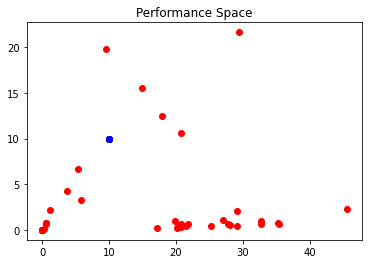

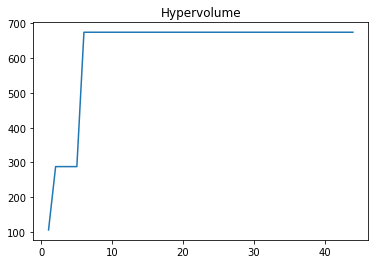

In [5]:
# plot
Y_eval = Y[Y0.shape[0]:, :]
plot_performance_space_diffcolor(Y0=-Y0, Y_eval=-Y_eval)
plot_performance_metric(Y, problem.obj_type)

In [8]:
y=2
def fun_x2 (x):
    return y+x
fun_x2(4)

6